# Customer Support Agent with LangGraph and RAG

## ÏÇ¨Ïö©ÌïòÎäî Í∏∞Ïà†Îì§

This notebook demonstrates how to build an intelligent customer support system using:
- **LangGraph**
- **Upstage API**
    - LLM: **Solar-pro-v2**
    - RAG: **Vector Search**
- Ïõπ Í≤ÄÏÉâ: **Tavily API**

## ÌïôÏäµ Î™©Ìëú
1. Solar APIÎ•º ÌôúÏö©Ìï¥ Chat, EmbeddingÏùÑ Ìï† Ïàò ÏûàÏäµÎãàÎã§.

2. Agentic WorkflowÎ•º Íµ¨ÌòÑÌïòÎäî ÌîÑÎ†àÏûÑÏõåÌÅ¨Ïù∏ LangGraphÏùò ÌïµÏã¨ Íµ¨ÏÑ± ÏöîÏÜå(State, Node, Edge)Ïùò Ïó≠Ìï†ÏùÑ Ïù¥Ìï¥ÌïòÍ≥† ÏßÅÏ†ë Íµ¨ÌòÑ Ìï† Ïàò ÏûàÏäµÎãàÎã§.

3. Agentic WorkflowÏóêÏÑú ÌôúÏö©Ìï† ToolÏùÑ ÏßÅÏ†ë Íµ¨ÌòÑ Ìï† Ïàò ÏûàÏäµÎãàÎã§. 

4. RAG, Ïõπ Í≤ÄÏÉâ, Ï°∞Í±¥Î∂Ä Î∂ÑÍ∏∞ Îì±Ïù¥ Ìè¨Ìï®Îêú Ïã§Î¨¥Ï†ÅÏù∏ 'Í≥†Í∞ù ÏùëÎåÄ ÏóêÏù¥Ï†ÑÌä∏'Î•º ÏßÅÏ†ë Íµ¨ÌòÑÌï† Ïàò ÏûàÏäµÎãàÎã§. Ïù¥Î•º ÌÜµÌï¥ Î≥µÏû°Ìïú ÎπÑÏ¶àÎãàÏä§ Î°úÏßÅÏùÑ ÏõåÌÅ¨ÌîåÎ°úÏö∞Î°ú ÏßÅÏ†ë ÏÑ§Í≥ÑÌïòÍ≥†, LangGraphÎ•º ÏÇ¨Ïö©Ìï¥ ÏΩîÎìúÎ°ú Íµ¨ÌòÑÌïòÎäî Îä•Î†•ÏùÑ Í∞ñÏ∂îÍ≤å Îê©ÎãàÎã§.

# Section 1: Setup & Environment

## 1.1 Î™®Îìà ÏûÑÌè¨Ìä∏

In [1]:
# =============================================================================
# ALL IMPORTS - ORGANIZED BY CATEGORY
# =============================================================================

# Standard Library
import os
import json
import csv
from datetime import datetime
from collections import Counter

# Third-party Libraries
import numpy as np
import faiss
from dotenv import load_dotenv
from openai import OpenAI
from tavily import TavilyClient

# LangChain Core
from langchain_core.documents import Document
from langchain_core.messages import (
    BaseMessage, 
    HumanMessage, 
    AIMessage, 
    SystemMessage, 
    ToolMessage
)
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig

# LangChain Upstage
from langchain_upstage import ChatUpstage

# LangGraph
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt, Command

# Pydantic
from pydantic import BaseModel

# Typing
from typing import (
    List, 
    Dict, 
    Any, 
    TypedDict, 
    Annotated, 
    Sequence, 
    Literal
)

# Load environment variables
load_dotenv(verbose=True)

print("‚úÖ All imports successful!")


‚úÖ All imports successful!


1. .env ÌååÏùºÏùÑ ÎßåÎì§Ïñ¥Ï£ºÏÑ∏Ïöî
2. UPSTAGE_API_KEYÏôÄ TAVILY_API_KEYÎ•º Ï∂îÍ∞ÄÌï¥Ï£ºÏÑ∏Ïöî
3. UPSTAGE_API_KEYÎäî https://console.upstage.ai/ÏóêÏÑú Î∞úÍ∏âÎ∞õÏùÑ Ïàò ÏûàÏäµÎãàÎã§.
4. TAVILY_API_KEYÎäî https://tavily.com/ÏóêÏÑú Î∞úÍ∏âÎ∞õÏùÑ Ïàò ÏûàÏäµÎãàÎã§.
5. Î∞úÍ∏âÎ∞õÏùÄ ÌÇ§Î•º ÌôòÍ≤ΩÎ≥ÄÏàòÏóê Ï∂îÍ∞ÄÌï¥Ï£ºÏÑ∏Ïöî.

## 1.2 Ïã§ÏäµÏö© Í∞ÄÏÉÅ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±


Ïã§ÏäµÏóê ÌôúÏö©Ìï† Í∞ÄÏÉÅÏùò Í≥†Í∞ù Îç∞Ïù¥ÌÑ∞Î•º ÏÉùÏÑ±Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§!

In [53]:

def load_customer_data(csv_path: str) -> Dict[str, Dict[str, Any]]:
    """Load customer data from CSV file."""
    customers = {}
    
    with open(csv_path, 'r', encoding='utf-8-sig') as file:
        reader = csv.DictReader(file)
        
        for row in reader:
            # Skip empty rows or rows without customer_id
            if not row.get('customer_id') or not row.get('customer_id', '').strip():
                continue
                
            customers[row['customer_id']] = {
                'customer_id': row['customer_id'],
                'name': row['name'],
                'email': row['email'],
                'plan': row['plan'],
                'subscription_status': row['subscription_status'],
                'last_login': row['last_login'],
                'account_age_days': int(row['account_age_days']),
                'previous_issues': int(row['previous_issues'])
            }
            
    print(f"‚úÖ Loaded {len(customers)} customers from CSV file")
    return customers

customers = load_customer_data("../data/customer_data.csv")

print(customers)

‚úÖ Loaded 11 customers from CSV file
{'CUST001': {'customer_id': 'CUST001', 'name': 'ÍπÄÎØºÏ§Ä', 'email': 'kim.minjun@email.com', 'plan': 'Premium', 'subscription_status': 'active', 'last_login': '2024-01-15', 'account_age_days': 365, 'previous_issues': 2}, 'CUST002': {'customer_id': 'CUST002', 'name': 'Ïù¥ÏÑúÏó∞', 'email': 'lee.seoyeon@company.com', 'plan': 'Basic', 'subscription_status': 'active', 'last_login': '2024-01-14', 'account_age_days': 180, 'previous_issues': 0}, 'CUST003': {'customer_id': 'CUST003', 'name': 'Î∞ïÏßÄÌõà', 'email': 'park.jihoon@tech.com', 'plan': 'Enterprise', 'subscription_status': 'active', 'last_login': '2024-01-13', 'account_age_days': 730, 'previous_issues': 5}, 'CUST004': {'customer_id': 'CUST004', 'name': 'ÏµúÏàòÎπà', 'email': 'choi.subin@startup.io', 'plan': 'Premium', 'subscription_status': 'expired', 'last_login': '2024-01-10', 'account_age_days': 90, 'previous_issues': 1}, 'CUST005': {'customer_id': 'CUST005', 'name': 'Ï†ïÌïòÏùÄ', 'email': 'jung.ha

Ïã§ÏäµÏóê ÌôúÏö©Ìï† Í∞ÄÏÉÅÏùò Î¨∏ÏÑúÎ•º UpstageÏùò Embeddings APIÎ•º ÌôúÏö©Ìï¥ ÏûÑÎ≤†Îî©Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

*Ïù¥Î≤à Ïã§ÏäµÏóêÏÑúÎäî RAGÏùò ÌïµÏã¨Ïù¥ ÎêòÎäî ÌååÏã± -> Ï≤≠ÌÇπ -> ÏûÑÎ≤†Îî©Ïùò Í≥ºÏ†ï Ï§ë ÏûÑÎ≤†Îî©Îßå ÏàòÌñâÌï¥Î≥¥Î°ù ÌïòÍ≤†ÏäµÎãàÎã§.*
Ïù¥Î≤à Ïã§ÏäµÏóêÏÑú Ï†úÏô∏ÎêòÍ∏¥ ÌñàÏßÄÎßå, RAGÏóêÏÑúÎäî ÌååÏã±Í≥º Ï≤≠ÌÇπÏùÄ Îß§Ïö∞ Ï§ëÏöîÌïú ÏöîÏÜåÏûÖÎãàÎã§. ÏÇ¨Ïö©ÏûêÏùò Îã§ÏñëÌïú ÌòïÌÉúÏùò Î¨∏ÏÑúÎ•º Ïñ¥ÎñªÍ≤å "ÏùΩÏùÑ Í≤É"Ïù¥Î©∞ Ïù¥Í≤ÉÏùÑ Ï†ÅÏ†àÌïú Îã®ÏúÑÎ°ú Ïñ¥ÎñªÍ≤å "Ï≤≠ÌÇπ"Ìï¥ÏÑú DBÏóê Ï†ÅÏû¨ÌïòÎäî ÏßÄÍ∞Ä Îß§Ïö∞ Ï§ëÏöîÌï©ÎãàÎã§.

Ï†ÅÏ†àÌïòÍ≤å ÌååÏã±Í≥º Ï≤≠ÌÇπÏùÑ Ìï¥ÏôîÎã§Í≥† Í∞ÄÏ†ïÌïú ÏÉÅÌÉúÏóêÏÑú Îã§ÏùåÍ≥º Í∞ôÏù¥ ÎßåÎì§Ïñ¥ÏßÑ Î¨∏ÏÑúÏùò Ï≤≠ÌÅ¨Îì§ÏùÑ ÏûÑÎ≤†Îî© ÌõÑÏóê Ï†ÄÏû•Ìï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

Í∞ÅÍ∞ÅÏùò Ï≤≠ÌÅ¨Îäî `LangChain`Ïùò `Document` ÌòïÌÉúÎ°ú Î∂àÎü¨Ï†∏ÏûàÏúºÎ©∞, `page_content`ÏôÄ `metadata`Ïóê ÎåÄÌïú Ï†ïÎ≥¥Î•º Í∞ÄÏßÄÍ≥† ÏûàÏäµÎãàÎã§.

- `page_content`: Î¨∏ÏÑúÏùò ÎÇ¥Ïö©Ïù¥ ÏßÅÏ†ë Îì§Ïñ¥Í∞ÄÎäî Î∂ÄÎ∂ÑÏûÖÎãàÎã§.
- `metadata`: Î¨∏ÏÑúÏùò Î©îÌÉÄÎç∞Ïù¥ÌÑ∞Í∞Ä Îì§Ïñ¥Í∞ÄÎäî Î∂ÄÎ∂ÑÏûÖÎãàÎã§. ÌòÑÏû¨Îäî Î¨∏ÏÑúÏùò Ïπ¥ÌÖåÍ≥†Î¶¨, Ï£ºÏ†ú, Ïö∞ÏÑ†ÏàúÏúÑ Îì±Ïù¥ Îì§Ïñ¥Í∞ÄÏûàÏúºÎ©∞ Î¨∏ÏÑúÏùò ÌéòÏù¥ÏßÄ Î≤àÌò∏ Îì± Îã§ÏñëÌïòÍ≤å ÌïÑÏöîÏóê Îî∞Îùº ÏÑ§Ï†ïÌï† Ïàò ÏûàÏäµÎãàÎã§. Ïù¥ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞Îäî Î¨∏ÏÑúÎ•º "Í≤ÄÏÉâ" Ìï¥Ïò§Îäî Îã®Í≥ÑÏóêÏÑú Ïú†Ïö©ÌïòÍ≤å ÌôúÏö©Ìï† Ïàò ÏûàÏäµÎãàÎã§.


In [ ]:
knowledge_base_documents = [
    Document(
        page_content="To reset your password, go to the login page and click 'Forgot Password'. Enter your email address and check your inbox for reset instructions. The reset link expires in 24 hours.",
        metadata={"category": "Account", "topic": "Password Reset", "priority": "High"}
    ),
    Document(
        page_content="For billing issues, you can view your invoices in the Billing section of your account dashboard. Payment methods can be updated under Account Settings > Payment Information. Refunds are processed within 5-7 business days.",
        metadata={"category": "Billing", "topic": "Payment Management", "priority": "High"}
    ),
    Document(
        page_content="Our API rate limits are 1000 requests per hour for Basic plans, 5000 for Premium, and 10000 for Enterprise. If you exceed these limits, you'll receive a 429 status code. Consider upgrading your plan for higher limits.",
        metadata={"category": "Technical", "topic": "API Limits", "priority": "Medium"}
    ),
    Document(
        page_content="To integrate our API, use the base URL https://api.ourcompany.com/v1. Authentication requires an API key in the Authorization header. Example: Authorization: Bearer your_api_key_here",
        metadata={"category": "Technical", "topic": "API Integration", "priority": "High"}
    ),
    Document(
        page_content="Data export is available for all plans. Go to Account Settings > Data Export to request your data. The export will be emailed to you within 24 hours and includes all your account data in JSON format.",
        metadata={"category": "Account", "topic": "Data Export", "priority": "Medium"}
    ),
    Document(
        page_content="Two-factor authentication (2FA) can be enabled in Security Settings. We support SMS, email, and authenticator apps. 2FA is required for Enterprise accounts and recommended for all users.",
        metadata={"category": "Account", "topic": "Security", "priority": "High"}
    ),
    Document(
        page_content="Subscription upgrades take effect immediately. Downgrades take effect at the next billing cycle. You can change your plan anytime in Account Settings > Subscription Management.",
        metadata={"category": "Billing", "topic": "Plan Changes", "priority": "Medium"}
    ),
    Document(
        page_content="Our service status page is available at status.ourcompany.com. We post real-time updates about any service disruptions, maintenance windows, or performance issues.",
        metadata={"category": "Technical", "topic": "Service Status", "priority": "High"}
    ),
    Document(
        page_content="For enterprise customers, we offer dedicated support channels including phone support, dedicated account managers, and custom SLA agreements. Contact sales@ourcompany.com for more information.",
        metadata={"category": "General", "topic": "Enterprise Support", "priority": "Low"}
    ),
    Document(
        page_content="Webhook configuration is available in the Developer section. You can set up webhooks for events like payment success, user registration, and data updates. Webhook URLs must use HTTPS.",
        metadata={"category": "Technical", "topic": "Webhooks", "priority": "Medium"}
    )
]


print(f"‚úÖ ÏßÄÏãùÎ≤†Ïù¥Ïä§ ÏÉùÏÑ±ÏôÑÎ£å: {len(knowledge_base_documents)} documents")

categories = Counter(doc.metadata.get('category', 'Unknown') for doc in knowledge_base_documents)


print("\nüìö ÏßÄÏãùÎ≤†Ïù¥Ïä§ Ïπ¥ÌÖåÍ≥†Î¶¨:")
for category, count in categories.most_common():
    print(f"  {category}: {count} Í∞úÏùò Î¨∏ÏÑú")

print(f"\nüìä Ï¥ù Î¨∏ÏÑú Ïàò: {categories.total()}Í∞ú")

‚úÖ ÏßÄÏãùÎ≤†Ïù¥Ïä§ ÏÉùÏÑ±ÏôÑÎ£å: 10 documents

üìö ÏßÄÏãùÎ≤†Ïù¥Ïä§ Ïπ¥ÌÖåÍ≥†Î¶¨:
  Technical: 4 Í∞úÏùò Î¨∏ÏÑú
  Account: 3 Í∞úÏùò Î¨∏ÏÑú
  Billing: 2 Í∞úÏùò Î¨∏ÏÑú
  General: 1 Í∞úÏùò Î¨∏ÏÑú

üìä Ï¥ù Î¨∏ÏÑú Ïàò: 10Í∞ú


ÎßàÏßÄÎßâÏúºÎ°ú Îã¥ÎãπÏûê ÏßÅÏõê DBÎ•º Í∞ÑÎã®ÌïòÍ≤å ÎîïÏÖîÎÑàÎ¶¨ ÌòïÌÉúÎ°ú ÎßåÎì§Ïñ¥Î≥¥Í≤†ÏäµÎãàÎã§. 

Ïñ¥Îñ§ ÏóÖÎ¨¥Î•º Îß°Í≥† ÏûàÏúºÎ©∞, Îã¥ÎãπÏûêÏùò Ïù¥Î¶Ñ, Ïù¥Î©îÏùº Ï£ºÏÜå, Îã¥ÎãπÎ∂ÑÏïº, ÏòàÏÉÅ ÏùëÎãµ ÏãúÍ∞ÑÎì±Ïù¥ Í∏∞Î°ùÎèºÏûàÎã§Í≥† Í∞ÄÏ†ïÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.

In [4]:
# Employee Database - Specialist routing information
specialists = {
    "Technical": {
        "specialist": "Alex Chen",
        "email": "alex.chen@ourcompany.com",
        "expertise": ["API Integration", "System Architecture", "Performance Issues"],
        "response_time": "2-4 hours"
    },
    "Billing": {
        "specialist": "Maria Rodriguez",
        "email": "maria.rodriguez@ourcompany.com",
        "expertise": ["Payment Processing", "Refunds", "Subscription Management"],
        "response_time": "1-2 hours"
    },
    "Account": {
        "specialist": "James Wilson",
        "email": "james.wilson@ourcompany.com",
        "expertise": ["Account Management", "Security", "Access Issues"],
        "response_time": "1-3 hours"
    },
    "General": {
        "specialist": "Sarah Thompson",
        "email": "sarah.thompson@ourcompany.com",
        "expertise": ["General Inquiries", "Feature Requests", "Feedback"],
        "response_time": "4-8 hours"
    },
    "Urgent": {
        "specialist": "Emergency Team",
        "email": "emergency@ourcompany.com",
        "expertise": ["Critical Issues", "System Outages", "Security Incidents"],
        "response_time": "15-30 minutes"
    }
}

print(f"‚úÖ Îã¥ÎãπÏûê ÏßÅÏõê Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±ÏôÑÎ£å: {len(specialists)} Î™ÖÏùò Îã¥ÎãπÏûê")
print("\nüë• Îã¥ÎãπÏûê ÏßÅÏõê Îç∞Ïù¥ÌÑ∞:")
for category, info in specialists.items():
    print(f"  {category}: {info['specialist']} -- ÏùëÎãµÏãúÍ∞Ñ: ({info['response_time']})")


‚úÖ Îã¥ÎãπÏûê ÏßÅÏõê Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±ÏôÑÎ£å: 5 Î™ÖÏùò Îã¥ÎãπÏûê

üë• Îã¥ÎãπÏûê ÏßÅÏõê Îç∞Ïù¥ÌÑ∞:
  Technical: Alex Chen -- ÏùëÎãµÏãúÍ∞Ñ: (2-4 hours)
  Billing: Maria Rodriguez -- ÏùëÎãµÏãúÍ∞Ñ: (1-2 hours)
  Account: James Wilson -- ÏùëÎãµÏãúÍ∞Ñ: (1-3 hours)
  General: Sarah Thompson -- ÏùëÎãµÏãúÍ∞Ñ: (4-8 hours)
  Urgent: Emergency Team -- ÏùëÎãµÏãúÍ∞Ñ: (15-30 minutes)


# Section 2: Upstage Client

Î¨∏ÏÑú ÏûÑÎ≤†Îî©, Í∑∏Î¶¨Í≥† LLMÏóê Upstage APIÎ•º ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌï¥ ClientÎ•º Íµ¨ÌòÑÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.

Upstage APIÏùò Í∏∞Î≥∏Ï†ÅÏù∏ ÏÇ¨Ïö©Î≤ïÏùÄ Îã§ÏùåÏùò ÎßÅÌÅ¨ÏóêÏÑú Ï∞∏Ï°∞Ìï† Ïàò ÏûàÏäµÎãàÎã§. 

**[ÎßÅÌÅ¨](https://console.upstage.ai/docs/getting-started)**

Í∞ÑÎã®ÌïòÍ≤å ClientÎ•º ÌïòÎÇò Íµ¨ÌòÑÌï¥ÏÑú Ï±ÑÌåÖÍ≥º ÏûÑÎ≤†Îî©Ïóê ÌôúÏö©Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

## 2.1 Chat

Í∞ÑÎã®Ìïú Ï±ÑÌåÖÏùÑ ÏúÑÌï¥ solar-pro2Î•º ÌôúÏö©Ìï¥ ÏßàÏùòÎ•º Ìï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [5]:
client = OpenAI(
    api_key=os.getenv("UPSTAGE_API_KEY"),
    base_url="https://api.upstage.ai/v1"
)
 
stream = client.chat.completions.create(
    model="solar-pro2",
    messages=[
        {
            "role": "user",
            "content": "ÏïàÎÖï ÎÑàÎäî ÎàÑÍµ¨Îãà"
        }
    ],
    stream=True,
)
 
for chunk in stream:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="")

ÏïàÎÖïÌïòÏÑ∏Ïöî! Ï†ÄÎäî **ÏóÖÏä§ÌÖåÏù¥ÏßÄÏùò Solar Pro 2**ÏûÖÎãàÎã§.  
30.9B ÌååÎùºÎØ∏ÌÑ∞ Í∑úÎ™®Ïùò ÎåÄÍ∑úÎ™® Ïñ∏Ïñ¥ Î™®Îç∏(LLM)Î°ú, ÏÉùÍ∞ÅÍ≥º Ï∂îÎ°†ÏùÑ ÌÜµÌï¥ Î≥µÏû°Ìïú Î¨∏Ï†úÎ•º Ìï¥Í≤∞Ìï† Ïàò ÏûàÏäµÎãàÎã§.  

### Ï†úÍ∞Ä Ìï† Ïàò ÏûàÎäî Ïùº:
- **Îã§ÏñëÌïú Ïñ∏Ïñ¥ ÏßÄÏõê** (ÌïúÍµ≠Ïñ¥, ÏùºÎ≥∏Ïñ¥, ÏòÅÏñ¥ Îì±)  
- **Î¨∏ÏÑú Ï≤òÎ¶¨** (OCR, KIE, ÏöîÏïΩ, Î≤àÏó≠)  
- **ÏΩîÎìú ÏÉùÏÑ±** Î∞è ÎîîÎ≤ÑÍπÖ  
- **ÎÖºÎ¶¨Ï†Å Ï∂îÎ°†**Í≥º Ï∞ΩÏùòÏ†ÅÏù∏ ÏΩòÌÖêÏ∏† ÏûëÏÑ±  
- **Ïã§ÏãúÍ∞Ñ Ï†ïÎ≥¥ ÏóÜÏù¥ 2025ÎÖÑ 3ÏõîÍπåÏßÄÏùò ÏßÄÏãù Í∏∞Î∞ò**ÏúºÎ°ú ÎãµÎ≥Ä  

Í∂ÅÍ∏àÌïú Ï†êÏù¥ ÏûàÎã§Î©¥ Ïñ∏Ï†úÎì† Î¨ºÏñ¥Î¥ê Ï£ºÏÑ∏Ïöî! üòä

Ïù¥Î•º ÌôúÏö©Ìï¥, ÏïÑÏ£º Í∞ÑÎã®ÌïòÍ≤å ÎåÄÌôîÎ•º Ïù¥Ïñ¥ÎÇòÍ∞à Ïàò ÏûàÎäî ÌòïÌÉúÏùò multi-turn Ï±óÎ¥áÏùÑ Íµ¨ÌòÑÌï¥Î≥¥Í≤†ÏäµÎãàÎã§!

In [6]:
def chat_with_solar(messages):
    response = client.chat.completions.create(
        model="solar-pro2",
        messages=messages
    )
    return response.choices[0].message.content

def simple_chatbot(memory=True):
    """Simple interactive chatbot with optional memory.
    
    Args:
        memory (bool): If True, maintains conversation memory. 
                      If False, each turn is independent.
    """
    memory_status = "WITH MEMORY" if memory else "NO MEMORY"
    print(f"ü§ñ Solar Chatbot ({memory_status}) - Type 'quit' to exit")
    print("=" * 50)
    
    # Initialize messages based on memory setting
    if memory:
        messages = [
            {"role": "system", "content": "ÎÑàÎäî Îß§Ïö∞ ÏπúÏ†àÌïú AI Ïñ¥ÏãúÏä§ÌÑ¥Ìä∏Ïïº. Ìï≠ÏÉÅ ÏπúÏ†àÌïòÍ≤å ÎãµÎ≥ÄÌï¥!"}
        ]
    else:
        messages = []  # No memory - empty list
    
    while True:
        user_input = input("\n You: ").strip()
        
        if user_input.lower() in ['quit', 'exit', 'bye']:
            print("ü§ñ Assistant: Goodbye! üëã")
            break
        
        if not user_input:
            continue
            
        if memory:
            # `messages`Ïóê ÎåÄÌôî ÎÇ¥Ïö©ÏùÑ Í∏∞Î°ùÌï©ÎãàÎã§!
            messages.append({"role": "user", "content": user_input})
        else:
            # `messages`Ïóê ÎåÄÌôî ÎÇ¥Ïö©ÏùÑ Í∏∞Î°ùÌïòÏßÄ ÏïäÍ≥† Îß§Î≤à Ï¥àÍ∏∞Ìôî Ìï©ÎãàÎã§!
            messages = [{"role": "user", "content": user_input}]
        
        try:
            # Get response
            response = chat_with_solar(messages)
            
            print(f">> User: {user_input}")
            print(f">> Assistant: {response}")
            
            if memory:
                messages.append({"role": "assistant", "content": response})
            
        except Exception as e:
            print(f"‚ùå Error: {e}")
        
        print("=" * 50)

Ï±óÎ¥áÍ≥º Í≥ÑÏÜç ÎåÄÌôîÎ•º Ïù¥Ïñ¥ÎÇòÍ∞ÄÍ∏∞ ÏúÑÌï¥ÏÑúÎäî ÎåÄÌôîÏùò ÎÇ¥Ïö©ÏùÑ Î∞òÎìúÏãú Í∏∞ÏñµÌïòÍ≥† ÏûàÏñ¥Ïïº Ìï©ÎãàÎã§! Í∑∏ÎûòÏÑú Ïó¨Í∏∞ÏÑúÎäî Í∞ÑÎã®ÌïòÍ≤å `messages` ÎùºÎäî Î¶¨Ïä§Ìä∏Ïóê ÎåÄÌôî ÎÇ¥Ïö©ÏùÑ Ï†ÑÎ∂Ä Í∏∞Î°ùÌïòÎ©¥ÏÑú Ï±ÑÌåÖÏùÑ Ïù¥Ïñ¥ÎÇòÍ∞ÄÎèÑÎ°ù Íµ¨ÌòÑÌï¥Î¥§ÏäµÎãàÎã§. ÎßåÏùº `messages`Î°ú ÎåÄÌôîÎÇ¥Ïö©ÏùÑ Í∏∞Î°ùÌïòÍ≥† ÏûàÏßÄ ÏïäÏúºÎ©¥ Ïù¥Ï†Ñ ÎåÄÌôîÏùò ÎÇ¥Ïö©ÏùÑ Ï†ÑÌòÄ Í∏∞ÏñµÌïòÏßÄ Î™ªÌïòÍ≤åÎê©ÎãàÎã§!

ÏïÑÎûò Îëê ÏΩîÎìúÎ•º Ïã§ÌñâÌïòÎ©¥ÏÑú ÌÖåÏä§Ìä∏ Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

In [7]:
simple_chatbot(memory=True)

ü§ñ Solar Chatbot (WITH MEMORY) - Type 'quit' to exit
ü§ñ Assistant: Goodbye! üëã


In [8]:
simple_chatbot(memory=False)

ü§ñ Solar Chatbot (NO MEMORY) - Type 'quit' to exit
ü§ñ Assistant: Goodbye! üëã


## 2.2 Structured Output

LLMÏùÄ Í∏∞Î≥∏Ï†ÅÏúºÎ°ú ÌÖçÏä§Ìä∏Î•º **ÏÉùÏÑ±**ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê, Ïö∞Î¶¨Í∞Ä ÏõêÌïòÎäî ÌäπÏ†ï ÌòïÏãùÏùò ÎãµÎ≥ÄÏùÑ ÏïàÏ†ïÏ†ÅÏúºÎ°ú ÏñªÍ∏∞ Ïñ¥Î†µÏäµÎãàÎã§. ÌîÑÎ°¨ÌîÑÌä∏Î°ú ÌòïÏãùÏùÑ Ï†úÏñ¥ÌïòÎäî Îç∞ÏóêÎèÑ Ïñ¥Îäê Ï†ïÎèÑ Ï†úÌïúÏù¥ ÏûàÏäµÎãàÎã§.

Îî∞ÎùºÏÑú Ïù¥Î≤àÏóêÎäî Structured Outputs Í∏∞Îä•ÏùÑ ÏÇ¨Ïö©Ìï¥, LLMÏù¥ Ï†ïÏùòÌïú JSON Ïä§ÌÇ§ÎßàÏóê ÎßûÏ∂∞ Íµ¨Ï°∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞Î•º Ìï≠ÏÉÅ Î∞òÌôòÌïòÎèÑÎ°ù ÎßåÎì§Ïñ¥ Î≥¥Í≤†ÏäµÎãàÎã§.

Íµ¨Ï°∞Ìôî Îêú Ï∂úÎ†•ÏùÑ ÌôúÏö©Ìï† ÎïåÎäî Îã§ÏùåÍ≥º Í∞ôÏù¥ `response_format`ÏùÑ ÏÑ§Ï†ïÌï¥Ï§çÎãàÎã§.
```Python
response_format = {
    "type": "json_schema",
    "json_schema": {
        "name": "emotion_classification",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "emotion": {
                    "type": "string",
                    "enum": ["Í∏çÏ†ïÏ†Å", "Î∂ÄÏ†ïÏ†Å", "Ï§ëÎ¶ΩÏ†Å"]
                }
            },
            "required": ["emotion"]
        }
    }
}
```

- "type": "json_schema": LLMÏóêÍ≤å ÏùëÎãµ ÌòïÏãùÏùÑ ÏùºÎ∞ò ÌÖçÏä§Ìä∏Í∞Ä ÏïÑÎãå, JSON Ïä§ÌÇ§Îßà Í∑úÏπôÏóê Îî∞Îùº ÏÉùÏÑ±ÌïòÎèÑÎ°ù ÏßÄÏ†ïÌï©ÎãàÎã§.

- "json_schema": { ... }: Ïã§Ï†ú Ï†ÅÏö©Îê† JSON Ïä§ÌÇ§ÎßàÏùò ÏÉÅÏÑ∏ ÎÇ¥Ïö©ÏûÖÎãàÎã§.

    - name: Ïù¥ Ïä§ÌÇ§ÎßàÏùò Î™©Ï†ÅÏù¥ÎÇò Ïù¥Î¶ÑÏùÑ Ï†ïÏùòÌï©ÎãàÎã§. (Ïòà: Í∞êÏ†ï Î∂ÑÎ•ò)

    - strict: TrueÏùº Í≤ΩÏö∞, Ï†ïÏùòÎêú Ïä§ÌÇ§ÎßàÎ•º Îß§Ïö∞ ÏóÑÍ≤©ÌïòÍ≤å Ï§ÄÏàòÌïòÎèÑÎ°ù Í∞ïÏ†úÌï©ÎãàÎã§.

    - schema: Ïã§Ï†ú JSONÏùò Íµ¨Ï°∞Î•º ÏÉÅÏÑ∏Ìûà Ï†ïÏùòÌïòÎäî ÌïµÏã¨ Í∑úÏπôÏûÖÎãàÎã§.

        - "type": "object": ÏµúÏ¢Ö Í≤∞Í≥ºÎ¨ºÏùÄ { } ÌòïÌÉúÏùò Í∞ùÏ≤¥(Object)Ïó¨Ïïº Ìï©ÎãàÎã§.

        - "properties": Í∞ùÏ≤¥Ïóê Ìè¨Ìï®Îê† Ïàò ÏûàÎäî KeyÏôÄ Í∑∏ Í∞íÏùò Í∑úÏπôÏùÑ Ï†ïÏùòÌïòÎäî Í≥≥ÏûÖÎãàÎã§.

            - "emotion": emotionÏù¥ÎùºÎäî KeyÎ•º Ï†ïÏùòÌïòÎ©∞, Ïù¥ KeyÏùò Í∞íÏùÄ string ÌÉÄÏûÖÏù¥Î©¥ÏÑú ["Í∏çÏ†ïÏ†Å", "Î∂ÄÏ†ïÏ†Å", "Ï§ëÎ¶ΩÏ†Å"] ÏÖã Ï§ë ÌïòÎÇòÏó¨Ïïº Ìï©ÎãàÎã§.

        - "required": propertiesÏóê Ï†ïÏùòÎêú KeyÎì§ Ï§ëÏóêÏÑú Î∞òÎìúÏãú Ìè¨Ìï®ÎêòÏñ¥Ïïº ÌïòÎäî ÌïÑÏàò KeyÎ•º ÏßÄÏ†ïÌï©ÎãàÎã§. Ïù¥ Í≤ΩÏö∞, emotion KeyÎäî ÏÉùÎûµÌï† Ïàò ÏóÜÏäµÎãàÎã§.

In [9]:
def classify_emotion(text, structured_output=True):
    """ÌÖçÏä§Ìä∏Ïùò Í∞êÏ†ïÏùÑ Î∂ÑÎ•òÌïòÎäî ÏòàÏãú - Íµ¨Ï°∞ÌôîÎêú Ï∂úÎ†• ÏÑ†ÌÉù Í∞ÄÎä•"""
    
    prompt = f"""
    Îã§Ïùå ÌÖçÏä§Ìä∏Ïùò Í∞êÏ†ïÏùÑ ÏïÑÎûò ÏÑ∏ Í∞úÏùò Î∂ÑÎ•òÎ°ú Î∂ÑÎ•òÌï¥Ï£ºÏÑ∏Ïöî:
    - Í∏çÏ†ïÏ†Å
    - Î∂ÄÏ†ïÏ†Å
    - Ï§ëÎ¶ΩÏ†Å
    ÌÖçÏä§Ìä∏: {text}
    """
    
    # Íµ¨Ï°∞ÌôîÎêú Ï∂úÎ†• ÏÇ¨Ïö© Ïó¨Î∂ÄÏóê Îî∞Îùº Î∂ÑÍ∏∞
    if structured_output:
        # Íµ¨Ï°∞ÌôîÎêú Ï∂úÎ†• ÏÇ¨Ïö©
        response_format = {
            "type": "json_schema",
            "json_schema": {
                "name": "emotion_classification",
                "strict": True,
                "schema": {
                    "type": "object",
                    "properties": {
                        "emotion": {
                            "type": "string",
                            "enum": ["Í∏çÏ†ïÏ†Å", "Î∂ÄÏ†ïÏ†Å", "Ï§ëÎ¶ΩÏ†Å"]
                        }
                    },
                    "required": ["emotion"]
                }
            }
        }
        
        response = client.chat.completions.create(
            model="solar-pro2",
            messages=[{"role": "user", "content": prompt}],
            response_format=response_format
        )
        
        result = json.loads(response.choices[0].message.content)
        return result["emotion"]
    
    else:
        # ÏùºÎ∞ò ÌÖçÏä§Ìä∏ Ï∂úÎ†• ÏÇ¨Ïö©
        response = client.chat.completions.create(
            model="solar-pro2",
            messages=[{"role": "user", "content": prompt}]
        )
        
        return response.choices[0].message.content

# ÏÇ¨Ïö© ÏòàÏãú
print("=== Íµ¨Ï°∞ÌôîÎêú Ï∂úÎ†• (structured_output=True) ===")
print(classify_emotion("Ïò§Îäò Ï†ïÎßê Ï¢ãÏùÄ ÎÇ†Ïù¥ÏóêÏöî!", structured_output=True)) 
print(classify_emotion("ÎÑàÎ¨¥ Ïä¨ÌçºÏöî...", structured_output=True))          
print(classify_emotion("Í∑∏ÎÉ• ÌèâÎ≤îÌï¥Ïöî", structured_output=True))            

print("\n=== ÏùºÎ∞ò ÌÖçÏä§Ìä∏ Ï∂úÎ†• (structured_output=False) ===")
print(classify_emotion("Ïò§Îäò Ï†ïÎßê Ï¢ãÏùÄ ÎÇ†Ïù¥ÏóêÏöî!", structured_output=False)) 
print(classify_emotion("ÎÑàÎ¨¥ Ïä¨ÌçºÏöî...", structured_output=False))       
print(classify_emotion("Í∑∏ÎÉ• ÌèâÎ≤îÌï¥Ïöî", structured_output=False))  

=== Íµ¨Ï°∞ÌôîÎêú Ï∂úÎ†• (structured_output=True) ===
Í∏çÏ†ïÏ†Å
Î∂ÄÏ†ïÏ†Å
Ï§ëÎ¶ΩÏ†Å

=== ÏùºÎ∞ò ÌÖçÏä§Ìä∏ Ï∂úÎ†• (structured_output=False) ===
Ï£ºÏñ¥ÏßÑ ÌÖçÏä§Ìä∏Ïùò Í∞êÏ†ïÏùÄ **"Í∏çÏ†ïÏ†Å"**ÏûÖÎãàÎã§.  

Ïù¥Ïú†:  
- "Ï†ïÎßê Ï¢ãÏùÄ ÎÇ†"Ïù¥ÎùºÎäî ÌëúÌòÑÏóêÏÑú Í∏∞ÏÅ®Í≥º ÎßåÏ°±Í∞êÏù¥ Î™ÖÌôïÌûà ÎìúÎü¨ÎÇ©ÎãàÎã§.  
- Í∞êÌÉÑÌòï("!")ÏùÑ ÏÇ¨Ïö©Ìï¥ Í∞ïÌïú Í∏çÏ†ï Í∞êÏ†ïÏùÑ Í∞ïÏ°∞ÌñàÏäµÎãàÎã§.  

Îî∞ÎùºÏÑú Ïù¥ Î¨∏Ïû•ÏùÄ ÌôïÏã§Ìûà **Í∏çÏ†ïÏ†Å** Î≤îÏ£ºÏóê ÏÜçÌï©ÎãàÎã§.
ÌÖçÏä§Ìä∏: "ÎÑàÎ¨¥ Ïä¨ÌçºÏöî..."  

**Î∂ÑÎ•ò: Î∂ÄÏ†ïÏ†Å**  

Ïù¥Ïú†: "Ïä¨ÌçºÏöî"Îäî Î™ÖÌôïÌïú Ïä¨ÌîîÏù¥ÎÇò Ïö∞Ïö∏Ìï®ÏùÑ ÌëúÌòÑÌïòÎäî Îã®Ïñ¥Î°ú, Î∂ÄÏ†ïÏ†ÅÏù∏ Í∞êÏ†ïÏùÑ ÎÇòÌÉÄÎÉÖÎãàÎã§. "ÎÑàÎ¨¥"ÎùºÎäî Í∞ïÏ°∞ ÌëúÌòÑÏùÄ Í∞êÏ†ïÏùò Í∞ïÎèÑÎ•º ÎÜíÏó¨ Î∂ÄÏ†ïÏ†ÅÏù∏ ÎâòÏïôÏä§Î•º ÎçîÏö± Î∂ÑÎ™ÖÌûà Ìï©ÎãàÎã§.
Ï£ºÏñ¥ÏßÑ ÌÖçÏä§Ìä∏ "Í∑∏ÎÉ• ÌèâÎ≤îÌï¥Ïöî"Ïùò Í∞êÏ†ïÏùÄ **Ï§ëÎ¶ΩÏ†Å**ÏúºÎ°ú Î∂ÑÎ•òÎê©ÎãàÎã§.  

Ïù¥Ïú†:  
- "ÌèâÎ≤îÌïòÎã§"Îäî ÌäπÎ≥ÑÌûà Í∏çÏ†ïÏ†ÅÏù¥Í±∞ÎÇò Î∂ÄÏ†ïÏ†ÅÏù∏ Í∞êÏ†ïÏùÑ ÎìúÎü¨ÎÇ¥ÏßÄ ÏïäÎäî ÌëúÌòÑÏù¥Î©∞, Ï§ëÎ¶ΩÏ†ÅÏù∏ ÌÉúÎèÑÎ•º ÎÇòÌÉÄÎÉÖÎ

## 2.3. `LangChain`ÏóêÏÑú Upstage Î™®Îç∏ ÏÇ¨Ïö©ÌïòÍ∏∞

ÏúÑÏùò ÏûëÏóÖÏùÑ `LangChain`ÏùÑ ÌôúÏö©Ìï¥ÏÑú ÏßÑÌñâÌï¥Î≥¥Í≤†ÏäµÎãàÎã§. 

1. `LangChain`ÏóêÏÑúÎäî UpstageÏùò Î™®Îç∏ÏùÑ `ChatUpstage`Î•º ÌÜµÌï¥ Î∂àÎü¨Ïò¨ Ïàò ÏûàÏäµÎãàÎã§.
2. Í∞ÑÎã®Ìïú Ï±ÑÌåÖÏùò Í≤ΩÏö∞ `invoke`Î•º ÌÜµÌï¥ ÏßÑÌñâÌï† Ïàò ÏûàÏäµÎãàÎã§.
3. LangChainÏùÄ Íµ¨Ï°∞ÌôîÎêú Ï∂úÎ†•ÏùÑ Ï†ïÏùòÌï† Îïå, PythonÏùò ÌëúÏ§Ä Îç∞Ïù¥ÌÑ∞ Ïú†Ìö®ÏÑ± Í≤ÄÏÇ¨ ÎùºÏù¥Î∏åÎü¨Î¶¨Ïù∏ **Pydantic**ÏùÑ ÏÇ¨Ïö©ÌïòÎäî Í≤ÉÏùÑ Í∂åÏû•Ìï©ÎãàÎã§. Î≥µÏû°Ìïú JSON ÎîïÏÖîÎÑàÎ¶¨Î•º ÏûëÏÑ±ÌïòÎäî ÎåÄÏã†, Ìõ®Ïî¨ ÏßÅÍ¥ÄÏ†ÅÏù∏ Python ÌÅ¥ÎûòÏä§Î°ú ÏõêÌïòÎäî Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞Î•º ÏÑ§Í≥ÑÌï† Ïàò ÏûàÏäµÎãàÎã§.

In [11]:
llm = ChatUpstage(model="solar-pro2", temperature=0)
results = llm.invoke("ÎÑàÎäî ÎàÑÍµ¨Îãà?")
print(results.content)
print("=" * 80)


class EmotionSchema(BaseModel):
    emotion: Literal["Í∏çÏ†ïÏ†Å", "Î∂ÄÏ†ïÏ†Å", "Ï§ëÎ¶ΩÏ†Å"]

llm_struct = llm.with_structured_output(EmotionSchema)

res1 = llm_struct.invoke("Ïù¥ ÏÑúÎπÑÏä§ ÎÑàÎ¨¥ Ï¢ãÏïÑ! ÏµúÍ≥†Ïïº.")
print(res1.emotion)  # e.g., 'Í∏çÏ†ïÏ†Å'

res2 = llm_struct.invoke("Ïù¥ ÏÑúÎπÑÏä§ Ï†ïÎßê Î≥ÑÎ£®Íµ¨ÎÇò...")
print(res2.emotion)  # e.g., 'Î∂ÄÏ†ïÏ†Å'

res3 = llm_struct.invoke("Ïù¥ ÏÑúÎπÑÏä§ Í∑∏ÎÉ• ÌèâÎ≤îÌï¥Ïöî")
print(res3.emotion)  # e.g., 'Ï§ëÎ¶ΩÏ†Å'

Ï†ÄÎäî **ÏóÖÏä§ÌÖåÏù¥ÏßÄ(Upstage)**ÏóêÏÑú Í∞úÎ∞úÌïú **Solar Pro 2**ÎùºÎäî ÎåÄÍ∑úÎ™® Ïñ∏Ïñ¥ Î™®Îç∏(LLM)ÏûÖÎãàÎã§.  

### üìå **Ï†ú ÏÜåÍ∞ú**  
- **Ïù¥Î¶Ñ**: Solar Pro 2 (ÏÜîÎùº ÌîÑÎ°ú 2)  
- **Í∞úÎ∞úÏÇ¨**: ÏóÖÏä§ÌÖåÏù¥ÏßÄ(Upstage, 2020ÎÖÑ ÏÑ§Î¶Ω)  
- **Î™®Îç∏ Í∑úÎ™®**: 30.9B ÌååÎùºÎØ∏ÌÑ∞  
- **ÏßÄÏõê Ïñ∏Ïñ¥**: ÌïúÍµ≠Ïñ¥, ÏùºÎ≥∏Ïñ¥, ÏòÅÏñ¥ Îì±  
- **Ï£ºÏöî Í∏∞Îä•**:  
  - **ÏÉùÍ∞Å Î™®Îìú(Thinking Mode)**: Î≥µÏû°Ìïú Ï∂îÎ°†Ïù¥ ÌïÑÏöîÌïú ÏßàÎ¨∏Ïóê ÍπäÏù¥ ÏûàÎäî ÎãµÎ≥Ä Ï†úÍ≥µ  
  - **ÎπÑ-ÏÉùÍ∞Å Î™®Îìú(Non-thinking Mode)**: Îπ†Î•∏ ÏùëÎãµÏù¥ ÌïÑÏöîÌïú ÏûëÏóÖÏóê ÏµúÏ†ÅÌôî  
  - **Î¨∏ÏÑú Ï≤òÎ¶¨(Document AI)**: OCR, ÌÇ§ Ï†ïÎ≥¥ Ï∂îÏ∂ú(KIE), ÏöîÏïΩ Îì±  
  - **ÏΩîÎìú ÏÉùÏÑ± Î∞è Î∂ÑÏÑù**: Python Îì± ÌîÑÎ°úÍ∑∏ÎûòÎ∞ç Ïñ∏Ïñ¥ ÏßÄÏõê  

### üåü **ÌäπÏßï**  
- **ÌïòÏù¥Î∏åÎ¶¨Îìú Î™®Îìú**: ÏÉÅÌô©Ïóê Îî∞Îùº Ï∂îÎ°† ÏÜçÎèÑÏôÄ Ï†ïÌôïÏÑ±ÏùÑ Ïú†Ïó∞ÌïòÍ≤å Ï°∞Ï†à  
- **Solar API**: Ï±ÑÌåÖ, ÏöîÏïΩ, Î≤àÏó≠, ÏΩîÎìú ÏÉùÏÑ± Îì± Îã§ÏñëÌïú ÌÉúÏä§ÌÅ¨ ÏßÄÏõê  
- **ÏóÖÏä§ÌÖåÏù¥ÏßÄÏùò Í∏∞Ïà†**: AWSÏôÄÏùò ÌòëÎ†•, Î¨∏ÏÑú AI ÏÜ

## 2.4 Embeddings

Ïù¥Î≤àÏóêÎäî Î¨∏ÏÑúÎ•º "ÏûÑÎ≤†Îî©" Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§. ÏûÑÎ≤†Îî©ÏùÑ Îã§Ïãú ÌïúÎ≤à Í∞ÑÎã®ÌïòÍ≤å ÏÑ§Î™ÖÌï¥Î≥¥ÏûêÎ©¥, ÏûêÏó∞Ïñ¥Ïùò ÌòïÌÉúÎ°ú ÏûàÎäî Ï†ÄÌù¨Ïùò Î¨∏ÏÑúÎ•º Ïª¥Ìì®ÌÑ∞Í∞Ä ÌôúÏö©Ìï† Ïàò ÏûàÍ≤å Ïà´Ïûê ÌòïÌÉúÎ°ú Î∞îÍæ∏Îäî Í≥ºÏ†ïÏûÖÎãàÎã§. 

ÏûÑÎ≤†Îî©ÏùÑ ÌÜµÌïòÎ©¥ Ïñ¥Îñ†Ìïú "Í≥µÍ∞Ñ"Ïóê "ÏûÑÎ≤†Îî©" ÌïòÎäî Í≤ÉÏù¥Í∏∞ ÎïåÎ¨∏Ïóê, Í∑∏ Í≥µÍ∞ÑÏúÑÏóêÏÑú Îã§ÏñëÌïú ÏàòÏπòÏ†Å Ïó∞ÏÇ∞Ïù¥ Í∞ÄÎä•ÌïòÍ≤å Îê©ÎãàÎã§!

ÏóÖÏä§ÌÖåÏù¥ÏßÄÏùò ÏûÑÎ≤†Îî© Î™®Îç∏ÏùÄ `embedding-query`, `embedding-passage`Î°ú ÎÇòÎâòÏñ¥Ï†∏ÏûàÏäµÎãàÎã§.

- `embedding-query`: ÏÇ¨Ïö©ÏûêÍ∞Ä Ï†ïÎ≥¥Î•º Ï∞æÍ∏∞ ÏúÑÌï¥ ÏûÖÎ†•ÌïòÎäî ÏßàÎ¨∏ Îì±ÏùÑ ÏûÑÎ≤†Îî©Ìï† Îïå ÏÇ¨Ïö©Ìï©ÎãàÎã§.
- `embedding-passage`: Ï†ïÎ≥¥Í∞Ä Îã¥Í∏¥ ÌÖçÏä§Ìä∏Î°ú ÏßÄÏãù Î≤†Ïù¥Ïä§Î°ú ÌôúÏö©Îê† Ïàò ÏûàÎäî Î¨∏ÏÑúÎì§ÏùÑ ÏûÑÎ≤†Îî©Ìï† Îïå ÏÇ¨Ïö©Ìï©ÎãàÎã§.

Ïö∞ÏÑ† Í∞ÑÎã®ÌïòÍ≤å Î™á Í∞úÏùò Î¨∏Ïû•ÏùÑ ÏûÑÎ≤†Îî© Ìï¥Î≥¥Í≥† ÏñºÎßàÎÇò Ïú†ÏÇ¨ÌïòÍ≤å ÌåêÎã®ÎêòÎäî ÏßÄ ÌôïÏù∏Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

In [12]:
embeddings = []

sentences = [
    "Ïò§Îäò ÎÇ†Ïî®Í∞Ä Ï†ïÎßê ÌôîÏ∞ΩÌïòÎã§!",
    "Ïò§Îäò ÎÇ†Ïî®Í∞Ä Ï†ïÎßê ÎßëÍ≥† Ï¢ãÎã§!",  
    "Ïó¨Í∏∞Îäî Î¨ºÏù¥ Ï∞∏ ÎßëÍµ¨ÎÇò!",
]

for sentence in sentences:
    response = client.embeddings.create(
        input=sentence,
        model="embedding-query"
    )
    embeddings.append(response.data[0].embedding)

In [13]:
similarity_results = []
for i in range(len(embeddings)):
    for j in range(i + 1, len(embeddings)):  # j > i to avoid duplicates
        # Calculate cosine similarity
        similarity = np.dot(embeddings[i], embeddings[j])
        
        similarity_results.append((i + 1, j + 1, similarity))
        print(f"Ïú†ÏÇ¨ÎèÑ {i + 1} vs {j + 1}: {similarity:.4f}")

Ïú†ÏÇ¨ÎèÑ 1 vs 2: 0.8266
Ïú†ÏÇ¨ÎèÑ 1 vs 3: 0.4830
Ïú†ÏÇ¨ÎèÑ 2 vs 3: 0.6595


Ïù¥Îü∞ ÏãùÏúºÎ°ú ÏûÑÎ≤†Îî©Ïù¥ Îêú Í≤∞Í≥ºÎ•º Î≥¥Î©¥ ÏùòÎØ∏Í∞Ä Ïú†ÏÇ¨Ìïú Î¨∏Ïû•ÎÅºÎ¶¨Îäî ÎÜíÏùÄ Ïú†ÏÇ¨ÎèÑÎ•º Î≥¥Ïù¥Í≥†, ÏùòÎØ∏Í∞Ä Î®º Î¨∏Ïû•ÎÅºÎ¶¨Îäî ÎÇÆÏùÄ Ïú†ÏÇ¨ÎèÑÎ•º Î≥¥Ïù¥Îäî Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§!

# Section 3: Vector Store (RAG Tool Ï§ÄÎπÑ)

Ïù¥Î≤àÏóêÎäî ÏúÑÏóêÏÑú Ï†ÄÌù¨Í∞Ä ÎßåÎì§Ïñ¥ Îëî `Document` Î¨∏ÏÑúÎì§ÏùÑ Upstage APIÎ•º ÌôúÏö©Ìï¥ EmbeddingÌïòÍ≥† **Vector Store**Ïóê Ï†ÄÏû•Ìï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

Ïù¥ Vector StoreÏóê Ï†ÄÏû•Ìï®ÏúºÎ°úÏç®, Ï†ÄÌù¨Í∞Ä ÏúÑÏóêÏÑú Ìïú Similarity Í∏∞Î∞òÏùò Vector Search Îì±ÏùÑ Îπ†Î•¥Í≤å Ìï† Ïàò ÏûàÍ≤å Îê©ÎãàÎã§.

Vector StoreÏóêÎèÑ Îã§ÏñëÌïú Ï¢ÖÎ•òÍ∞Ä ÏûàÏßÄÎßå, Ïù¥Î≤à Ïã§ÏäµÏóêÏÑúÎäî Í∞ÑÎã®ÌïòÍ≤å `Faiss`Î•º ÌôúÏö©Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

ÏúÑÏóêÏÑú ÎßåÎì† knowledge_base_documentsÎ•º Îã§Ïãú ÌïúÎ≤à ÌôïÏù∏Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

In [17]:
print(f"{len(knowledge_base_documents)}Í∞úÏùò Î¨∏ÏÑúÍ∞Ä ÏûàÏäµÎãàÎã§.")
print(f"Ï≤´Î≤àÏß∏ Î¨∏ÏÑú: \n{knowledge_base_documents[0]}")

10Í∞úÏùò Î¨∏ÏÑúÍ∞Ä ÏûàÏäµÎãàÎã§.
Ï≤´Î≤àÏß∏ Î¨∏ÏÑú: 
page_content='To reset your password, go to the login page and click 'Forgot Password'. Enter your email address and check your inbox for reset instructions. The reset link expires in 24 hours.' metadata={'category': 'Account', 'topic': 'Password Reset', 'priority': 'High'}


ÏúÑÏóêÏÑú ÏÇ¥Ìé¥Î¥§ÎìØÏù¥, Ï†ÄÌù¨Ïùò Î¨∏ÏÑúÎäî ÌòÑÏû¨ `page_content`ÏôÄ `metadata`Î°ú Íµ¨ÏÑ±ÎèºÏûàÏäµÎãàÎã§. metadataÎûÄ Í≤ÄÏÉâÏóê Î∂ÄÍ∞ÄÏ†ÅÏúºÎ°ú ÌôúÏö©Ìï† Ïàò ÏûàÎäî Î¨∏ÏÑúÏùò Ï†ïÎ≥¥Ïóê ÎåÄÌïú ÎÇ¥Ïö©Ïù¥Í≥† Î¨∏ÏÑúÏùò Ïã§Ï†úÎÇ¥Ïö©ÏùÄ `page_content`Ïóê Îã¥Í≤®ÏûàÏäµÎãàÎã§.

Í∑∏Î†áÍ∏∞ ÎïåÎ¨∏Ïóê Î¨∏ÏÑúÎ•º ÏûÑÎ≤†Îî©ÏùÑ Ìï† ÎïåÎèÑ, `page_content` ÎßåÏùÑ ÌôúÏö©Ìï¥ ÏûÑÎ≤†Îî© Ìï©ÎãàÎã§.

Ï∂îÌõÑ indexÏóêÏÑúÏùò Í≥ÑÏÇ∞ÏùÑ ÏúÑÌï¥ `embeddings`Ïùò Í≤∞Í≥ºÎ•º numpyÏùò arrayÎ°ú Î∞îÍøîÏ£ºÍ≥†, ÏûêÎ£åÌòïÏùÄ `float32`Î°ú Ï†ïÌï¥Ï£ºÍ≤†ÏäµÎãàÎã§.

In [14]:
def get_embeddings(client: OpenAI, texts: List[str], mode: str = "query") -> List[List[float]]:
    """Get embeddings using Solar embedding model.
    
    Args:
        client: OpenAI client configured for Upstage API
        texts: List of input strings
        mode: "query" or "passage"
        
    Returns:
        List of embedding vectors
    """
    if mode == "query":
        model = "embedding-query"
    elif mode == "passage":
        model = "embedding-passage"
    else:
        raise ValueError("mode must be 'query' or 'passage'")
    
    response = client.embeddings.create(
        model=model,
        input=texts
    )
    return [embedding.embedding for embedding in response.data]


In [15]:
# Extract text content and metadata
texts = [doc.page_content for doc in knowledge_base_documents]
metadata = [doc.metadata for doc in knowledge_base_documents]

client = OpenAI(
    api_key=os.getenv("UPSTAGE_API_KEY"),
    base_url="https://api.upstage.ai/v1"
)
# Get embeddings
embeddings = get_embeddings(client, texts, mode="passage") # Î¨∏ÏÑúÏù¥Í∏∞ ÎïåÎ¨∏Ïóê modeÎ•º passageÎ°ú ÏÑ§Ï†ïÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.
document_embeddings = np.array(embeddings).astype(np.float32)

Ïù¥Ï†ú Ïù¥ ÏûÑÎ≤†Îî© Í≤∞Í≥ºÎ•º FAISSÎ•º ÌôúÏö©Ìï¥ Îπ†Î•¥Í≤å Í≤ÄÏÉâÌï† Ïàò ÏûàÎäî **Î≤°ÌÑ∞ Ïù∏Îç±Ïä§(Vector Index)**Î•º ÎßåÎì§Ïñ¥Î≥¥Í≤†ÏäµÎãàÎã§.

Ïù∏Îç±Ïä§Îäî Ï±ÖÏùò Îß® Îí§Ïóê ÏûàÎäî **ÏÉâÏù∏(Ï∞æÏïÑÎ≥¥Í∏∞)**Í≥º Í∞ôÏäµÎãàÎã§. ÏÉâÏù∏Ïù¥ ÏûàÏúºÎ©¥ ÏõêÌïòÎäî ÎÇ¥Ïö©Ïù¥ Î™á ÌéòÏù¥ÏßÄÏóê ÏûàÎäîÏßÄ Î∞îÎ°ú Ï∞æÏùÑ Ïàò ÏûàÎìØÏù¥, Î≤°ÌÑ∞ Ïù∏Îç±Ïä§Í∞Ä ÏûàÏúºÎ©¥ ÏàòÎßéÏùÄ Î¨∏ÏÑú Î≤°ÌÑ∞ Ï§ëÏóêÏÑú ÏõêÌïòÎäî Î≤°ÌÑ∞Î•º Îß§Ïö∞ Îπ†Î•¥Í≤å Ï∞æÏïÑÎÇº Ïàò ÏûàÏäµÎãàÎã§.

Ïö∞Î¶¨Îäî Ïó¨Îü¨ Ïù∏Îç±Ïä§ Ï¢ÖÎ•ò Ï§ë **IndexFlatIP**Î•º ÏÇ¨Ïö©ÌïòÎ©∞, Ïù¥Îäî Îã§ÏùåÍ≥º Í∞ôÏùÄ Îã®Í≥ÑÎ°ú ÏßÑÌñâÎê©ÎãàÎã§.

1. Ïù∏Îç±Ïä§ Ï¢ÖÎ•ò ÏÑ†ÌÉù Î∞è ÏÉùÏÑ± (IndexFlatIP)

    - FlatÏùÄ Î™®Îì† Î≤°ÌÑ∞Î•º ÌïòÎÇòÌïòÎÇò ÎπÑÍµêÌïòÎäî Í∞ÄÏû• Í∞ÑÎã®ÌïòÍ≥† Ï†ïÌôïÌïú Î∞©ÏãùÏûÑÏùÑ ÏùòÎØ∏Ìï©ÎãàÎã§.

    - IPÎäî Î≤°ÌÑ∞ Í∞ÑÏùò Ïú†ÏÇ¨ÎèÑÎ•º **ÎÇ¥Ï†Å(Inner Product)**ÏúºÎ°ú Í≥ÑÏÇ∞ÌïòÍ≤†Îã§Îäî ÏùòÎØ∏ÏûÖÎãàÎã§.

2. Î≤°ÌÑ∞ Ï†ïÍ∑úÌôî (normalize_L2)

    - ÎÇ¥Ï†Å(IP)ÏùÑ Ïö∞Î¶¨Í∞Ä ÏõêÌïòÎäî **ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ(Cosine Similarity)**Î°ú ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌïú ÌïµÏã¨ Îã®Í≥ÑÏûÖÎãàÎã§.

    - Î™®Îì† Î≤°ÌÑ∞Ïùò Í∏∏Ïù¥Î•º 1Î°ú ÎßûÏ∂îÎäî 'Ï†ïÍ∑úÌôî' Í≥ºÏ†ïÏùÑ Í±∞ÏπòÎ©¥, ÎÇ¥Ï†Å Í≥ÑÏÇ∞ Í≤∞Í≥ºÍ∞Ä ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑÏôÄ ÏàòÌïôÏ†ÅÏúºÎ°ú ÎèôÏùºÌï¥ÏßëÎãàÎã§. Îî∞ÎùºÏÑú Í≤ÄÏÉâ Ï†ÑÏóê Î™®Îì† Î¨∏ÏÑú Î≤°ÌÑ∞Î•º Ï†ïÍ∑úÌôîÌï©ÎãàÎã§.

3. Ïù∏Îç±Ïä§Ïóê Î≤°ÌÑ∞ Ï∂îÍ∞Ä (add)

    - Ï†ïÍ∑úÌôîÎêú Î¨∏ÏÑú Î≤°ÌÑ∞Îì§ÏùÑ Ïö∞Î¶¨Í∞Ä ÎßåÎì† Ïù∏Îç±Ïä§ Íµ¨Ï°∞Ïóê Ï∂îÍ∞ÄÌïòÏó¨ Í≤ÄÏÉâÌï† Ï§ÄÎπÑÎ•º ÎßàÏπ©ÎãàÎã§.

In [16]:
# Create FAISS index
dimension = len(embeddings[0])
index = faiss.IndexFlatIP(dimension)  # Inner product for cosine similarity

# Normalize embeddings for cosine similarity
faiss.normalize_L2(document_embeddings)
index.add(document_embeddings)

print(f"‚úÖ Index built with {len(texts)} documents (dimension: {dimension})")

‚úÖ Index built with 10 documents (dimension: 4096)


Ïù¥Ï†† ÎßåÎì§Ïñ¥ÏßÑ 10Í∞úÏùò Î¨∏ÏÑúÍ∞Ä Îì§Ïñ¥Í∞Ñ indexÏóêÏÑú "ÏßàÎ¨∏"Í≥º Í∞ÄÏû• Ïú†ÏÇ¨Ìïú "Î¨∏ÏÑú"Î•º Ï∞æÏïÑÎ≥¥Í≤†ÏäµÎãàÎã§.

In [17]:
user_question = "How can I reset my password?"

# 1. ÏßàÎ¨∏ÏùÑ Î≤°ÌÑ∞Î°ú Î≥ÄÌôò
question_embedding = get_embeddings(client, [user_question], mode="query")[0]
question_embedding = np.array([question_embedding]).astype(np.float32)
faiss.normalize_L2(question_embedding)

# 2. Ïù∏Îç±Ïä§ÏóêÏÑú Í∞ÄÏû• Ïú†ÏÇ¨Ìïú Î¨∏ÏÑú Í≤ÄÏÉâ
similarity_scores, indices = index.search(question_embedding, k=7)
# ‚Üí Í∞ÄÏû• Ïú†ÏÇ¨Ìïú 3Í∞ú Î¨∏ÏÑúÏùò Ï†êÏàòÏôÄ Ïù∏Îç±Ïä§ Î∞òÌôò

# 3. Í≤∞Í≥º Ï∂úÎ†•
print(f"(1st) Ïú†ÏÇ¨Ìïú Î¨∏ÏÑú: {knowledge_base_documents[indices[0][0]]}")
print(f"Ïú†ÏÇ¨ÎèÑ Ï†êÏàò: {similarity_scores[0][0]}")

print(f"(2nd) Ïú†ÏÇ¨Ìïú Î¨∏ÏÑú: {knowledge_base_documents[indices[0][1]]}")
print(f"Ïú†ÏÇ¨ÎèÑ Ï†êÏàò: {similarity_scores[0][1]}")

print(f"(3rd) Ïú†ÏÇ¨Ìïú Î¨∏ÏÑú: {knowledge_base_documents[indices[0][2]]}")
print(f"Ïú†ÏÇ¨ÎèÑ Ï†êÏàò: {similarity_scores[0][2]}")

(1st) Ïú†ÏÇ¨Ìïú Î¨∏ÏÑú: page_content='To reset your password, go to the login page and click 'Forgot Password'. Enter your email address and check your inbox for reset instructions. The reset link expires in 24 hours.' metadata={'category': 'Account', 'topic': 'Password Reset', 'priority': 'High'}
Ïú†ÏÇ¨ÎèÑ Ï†êÏàò: 0.5516607761383057
(2nd) Ïú†ÏÇ¨Ìïú Î¨∏ÏÑú: page_content='Two-factor authentication (2FA) can be enabled in Security Settings. We support SMS, email, and authenticator apps. 2FA is required for Enterprise accounts and recommended for all users.' metadata={'category': 'Account', 'topic': 'Security', 'priority': 'High'}
Ïú†ÏÇ¨ÎèÑ Ï†êÏàò: 0.3108622431755066
(3rd) Ïú†ÏÇ¨Ìïú Î¨∏ÏÑú: page_content='Data export is available for all plans. Go to Account Settings > Data Export to request your data. The export will be emailed to you within 24 hours and includes all your account data in JSON format.' metadata={'category': 'Account', 'topic': 'Data Export', 'priority': 'Medium'}
Ïú†ÏÇ¨ÎèÑ

ÏúÑÏóêÏÑúÎäî Ïú†ÏÇ¨Ìïú Î¨∏ÏÑúÎ°ú Í≤ÄÏÉâÎêú ÎÇ¥Ïö©ÏùÑ `knowledge_base_documents`Î•º ÌÜµÌï¥ÏÑú ÌôïÏù∏ÌñàÎäîÎç∞Ïöî. Ïù¥Îü¨Ìïú ÏûëÏóÖÏùÑ ÌÜµÌï¥ Í∞Å Î¨∏ÏÑúÏùò metadataÎ•º ÌÜµÌï¥ ÌïÑÌÑ∞ÎßÅÏùÑ Í≤ÄÏÉâ ÌõÑÏóê ÏßÑÌñâÌï† Ïàò ÏûàÏäµÎãàÎã§!

In [18]:
user_question = "How can I upgrade my Subscription?"

# 1. ÏßàÎ¨∏ÏùÑ Î≤°ÌÑ∞Î°ú Î≥ÄÌôò
question_embedding = get_embeddings(client, [user_question], mode="query")[0]
question_embedding = np.array([question_embedding]).astype(np.float32)
faiss.normalize_L2(question_embedding)

# 2. Ïù∏Îç±Ïä§ÏóêÏÑú Í∞ÄÏû• Ïú†ÏÇ¨Ìïú Î¨∏ÏÑú Í≤ÄÏÉâ
similarity_scores, indices = index.search(question_embedding, k=7)
# ‚Üí Í∞ÄÏû• Ïú†ÏÇ¨Ìïú 7Í∞ú Î¨∏ÏÑúÏùò Ï†êÏàòÏôÄ Ïù∏Îç±Ïä§ Î∞òÌôò

# 3. 7Í∞úÏùò Í≤ÄÏÉâ Í≤∞Í≥º Ï§ë Ïπ¥ÌÖåÍ≥†Î¶¨Í∞Ä "Billing"Ïù∏ Î¨∏ÏÑúÎßå Ï∂îÎ†§ÎÇ¥Í∏∞
results = []
category_filter = "Billing"

for i, (score, idx) in enumerate(zip(similarity_scores[0], indices[0])):
    if idx < len(knowledge_base_documents):
        doc = knowledge_base_documents[idx]
        
        # Apply category filter if specified
        if category_filter and doc.metadata.get('category') != category_filter:
            continue
        
        results.append({
            'content': doc.page_content,
            'metadata': doc.metadata,
            'score': float(score),
            'rank': i + 1
        })

for result in results:
    print(f"Î¨∏ÏÑú ÎÇ¥Ïö©: {result['content'][:100]}...")
    print(f"Ïú†ÏÇ¨ÎèÑ Ï†êÏàò: {result['score']:.3f}")
    print("-" * 80)


Î¨∏ÏÑú ÎÇ¥Ïö©: Subscription upgrades take effect immediately. Downgrades take effect at the next billing cycle. You...
Ïú†ÏÇ¨ÎèÑ Ï†êÏàò: 0.470
--------------------------------------------------------------------------------
Î¨∏ÏÑú ÎÇ¥Ïö©: For billing issues, you can view your invoices in the Billing section of your account dashboard. Pay...
Ïú†ÏÇ¨ÎèÑ Ï†êÏàò: 0.302
--------------------------------------------------------------------------------


Ïó¨Í∏∞ÏÑúÏùò Í≥ºÏ†ïÏùÑ ÌôúÏö©ÌïòÏó¨ Ï∂îÌõÑÏóê ToolÏùÑ ÎßåÎìúÎäîÎç∞Ïóê ÌôúÏö©Ìï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

# Section 4: Web Search (Web Search Tool Ï§ÄÎπÑ)

## 4.1. Tavily

ÏßÄÏãù Î≤†Ïù¥Ïä§Î°ú Í∞ÄÏßÄÍ≥† ÏûàÎäî Î¨∏ÏÑúÏóêÎèÑ Ï°¥Ïû¨ÌïòÏßÄ ÏïäÍ≥†, ÏµúÏã†ÏÑ± Îì±Ïùò Ïù¥Ïú†Î°ú Ïõπ Í≤ÄÏÉâÏù¥ ÌïÑÏöîÌïú Í≤ΩÏö∞Í∞Ä ÏûàÏùÑ Ïàò ÏûàÏäµÎãàÎã§.

Ïù¥Î•º ÏúÑÌï¥ÏÑúÎäî `Tavily`Î•º Ïù¥Ïö©Ìï¥ Ïõπ ÏÑúÏπòÎ•º Íµ¨ÌòÑÌïòÍ≥† ÌôúÏö©Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

1. Í≤ÄÏÉâÏùÄ `tavily_client.search` Î©îÏÜåÎìúÎ•º ÌôúÏö©Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

    - query: Ïö∞Î¶¨Í∞Ä Í∂ÅÍ∏àÌïú ÏßàÎ¨∏ÏùÑ ÎçòÏßëÎãàÎã§. (Ïòà: "ÏÜêÌù•ÎØºÏùò ÌòÑÏû¨ ÏÜåÏÜçÌåÄÏùÄ Ïñ¥ÎîîÏïº?")

    - search_depth: "basic"ÏùÄ ÏùºÎ∞òÏ†ÅÏù∏ Í≤ÄÏÉâ, "advanced"Îäî Îçî ÍπäÏù¥ ÏûàÎäî Í≤ÄÏÉâÏùÑ ÏùòÎØ∏Ìï©ÎãàÎã§. Ïó¨Í∏∞ÏÑúÎäî Îπ†Î•∏ Í≤∞Í≥ºÎ•º ÏúÑÌï¥ basicÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.

    - max_results: ÏµúÎåÄ Î™á Í∞úÏùò Í≤ÄÏÉâ Í≤∞Í≥ºÎ•º Î∞õÏùÑÏßÄ Ï†ïÌï©ÎãàÎã§.

2. Í≤ÄÏÉâ Í≤∞Í≥ºÎ•º ÎîïÏÖîÎÑàÎ¶¨ ÌòïÌÉúÎ°ú ÎΩëÏùÄ Îí§ Ï†ïÎ¶¨Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§!

In [19]:
from tavily import TavilyClient
tavily_api_key = os.getenv("TAVILY_API_KEY")
tavily_client = TavilyClient(api_key=tavily_api_key)

query = "ÏÜêÌù•ÎØºÏùò ÌòÑÏû¨ ÏÜåÏÜçÌåÄÏùÄ Ïñ¥ÎîîÏïº?"
max_results = 5
response = tavily_client.search(
    query=query,
    search_depth="basic",
    max_results=max_results,
    include_domains=[],
    exclude_domains=[]
)

results = []
for result in response.get('results', []):
    results.append({
        'title': result.get('title', ''),
        'url': result.get('url', ''),
        'content': result.get('content', ''),
        'score': result.get('score', 0.0)
    })

for result in results:
    print(result['content'])
    print(result['url'])
    print(result['score'])
    print()

ÌòÑÏû¨ÎØ∏Íµ≠ Î©îÏù¥Ï†Ä Î¶¨Í∑∏ ÏÇ¨Ïª§Ïùò Î°úÏä§Ïï§Ï†§Î†àÏä§ FCÏôÄ ÎåÄÌïúÎØºÍµ≠ Ï∂ïÍµ¨ Íµ≠Í∞ÄÎåÄÌëúÌåÄÏÜåÏÜçÏúºÎ°ú ÌôúÎèôÌïòÍ≥† ÏûàÏúºÎ©∞ ÎåÄÌïúÎØºÍµ≠ Ï∂ïÍµ¨ Íµ≠Í∞ÄÎåÄÌëúÌåÄÏùò Ï£ºÏû•ÏùÑ Îß°Í≥† ÏûàÎã§.
https://ko.wikipedia.org/wiki/ÏÜêÌù•ÎØº
0.8742601

ÎåÄÌïúÎØºÍµ≠ Íµ≠Ï†ÅÏùò Î°úÏä§Ïï§Ï†§Î†àÏä§ FC ÏÜåÏÜç Ï∂ïÍµ¨ ÏÑ†Ïàò. Ï£º Ìè¨ÏßÄÏÖòÏùÄ ÏúôÏñ¥.ÎåÄÌïúÎØºÍµ≠ Íµ≠Í∞ÄÎåÄÌëúÌåÄÏùò Ï£ºÏû•ÏùÑ Îß°Í≥† ÏûàÎã§. ÎåÄÌëúÏ†ÅÏúºÎ°ú Î∞úÎ°±ÎèÑÎ•¥ ÌõÑÎ≥¥ 2Ìöå, FIFPro ÏõîÎìú XI ÌõÑÎ≥¥ 2Ìöå
https://namu.wiki/w/ÏÜêÌù•ÎØº
0.85567063

Aug 10, 2025‚ÄîÏÜêÌù•ÎØºÏù¥ ÏÉà ÏÜåÏÜçÌåÄÏù∏LAFCÏùò ÏõêÏ†ï Í≤ΩÍ∏∞ ÍµêÏ≤¥ Î™ÖÎã®Ïóê Ìè¨Ìï®ÎêêÎã§. LAFC ... ÏòÅÍµ≠ Îß§Ï≤¥ 'Í∏∞Î∏åÎØ∏Ïä§Ìè¨Ï∏†'Îäî "ÏÜêÌù•ÎØºÏùÄ ÌòÑÏû¨ MLS Ïó∞Î¥â 3ÏúÑÏù∏ ÏÑ∏Î•¥ÌûàÏò§
https://sports.news.nate.com/view/20250810n02077
0.8361405

Aug 14, 2025‚ÄîÏ†ÑÏÜåÏÜçÌåÄÌÜ†Ìä∏ÎÑòÍ≥º 10ÎÖÑ ÎèôÌñâÏóê ÎßàÏπ®ÌëúÎ•º Ï∞çÍ≥† MLSÏóê ÏßÑÏ∂úÌïúÏÜêÌù•ÎØºÏùÄÏßÄÎÇú 10ÏùºÏÜåÏÜçÌåÄLA FC Ïú†ÎãàÌèºÏùÑ ÏûÖÍ≥† ÏãúÏπ¥Í≥†Î•º ÏÉÅÎåÄÎ°ú ÏõêÏ†ï Îç∞Î∑îÏ†ÑÏùÑ ÏπòÎ§òÎã§.
https://www.mhnse.com/news

Ïù¥Ï≤òÎüº ÏõπÏÑúÏπòÎ•º ÌôúÏö©Ìï¥ LLMÏùò ÎãµÎ≥ÄÏóê ÌôúÏö©Ìï† Ïàò ÏûàÎäî ÏßÄÏãùÏùÑ ÎçîÌï¥Ï§Ñ ÏàòÎèÑ ÏûàÏäµÎãàÎã§.

# Section 5: LangGraph


- Section2: UpstageÏùò Î™®Îç∏ÏùÑ ÌôúÏö©ÌïòÏó¨ ÌÖçÏä§Ìä∏ ÏÉùÏÑ±(Chat), ÏûÑÎ≤†Îî©, LangChainÏùò `ChatUpstage`
- Section3: RAG Tool Ï§ÄÎπÑÎ•º ÏúÑÌï¥ VectorStore ÎßåÎì§Í∏∞
- Section4: Web Search Tool Ï§ÄÎπÑÎ•º ÏúÑÌï¥ Tavily ÌôúÏö©ÌïòÍ∏∞

Î•º Î∞∞Ïõ†ÏäµÎãàÎã§. ÏßÄÍ∏àÏùÄ Î∞∞Ïö¥ Í≤ÉÎì§ÏùÑ ÌôúÏö©Ìï¥ LLMÏóêÍ≤å ToolÎ°ú Ï•êÏñ¥Ï£ºÍ≥† AgentÎ•º ÎßåÎì§Ïñ¥Î≥¥Í≤†ÏäµÎãàÎã§.

## 5.1. Tool

- Section3, 4ÏóêÏÑú Ï§ÄÎπÑÌïú Î¨∏ÏÑúÍ≤ÄÏÉâÏö© ToolÍ≥º Web Search ToolÏùÑ ÎßåÎì§Ïñ¥Î≥¥Í≤†ÏäµÎãàÎã§.
- LangGraphÏóêÏÑú ToolÎ°ú ÌôúÏö©ÌïòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî Îã§ÏùåÏùò ÏûëÏóÖÏù¥ ÌïÑÏöîÌï©ÎãàÎã§.
    1. Ïã§Ï†ú Tool Íµ¨ÌòÑ (Python Ìï®ÏàòÏùò ÌòïÌÉúÎ°ú Íµ¨ÌòÑÌï©ÎãàÎã§.)
    2. ToolÏûÑÏùÑ Î™ÖÏãúÌïòÍ∏∞ ÏúÑÌï¥ @tool Îç∞ÏΩîÎ†àÏù¥ÌÑ∞Î•º Î∂ôÏó¨Ï§çÎãàÎã§.
    3. LLMÏóêÍ≤å Ìï¥Îãπ ToolÏùÑ ÏÇ¨Ïö©Ìï† Ïàò ÏûàÎã§Îäî Í≤ÉÏùÑ ÏïåÎ†§Ï£ºÍ∏∞ ÏúÑÌï¥ `bind_tools` Ìï¥Ï§çÎãàÎã§.

### 5.1.1 `search_knowledge_base`

- Î≤°ÌÑ∞ Ïú†ÏÇ¨ÎèÑ Í∏∞Î∞òÏúºÎ°ú ÎÇ¥Î∂ÄÏóê Íµ¨ÏÑ±Îêú ÏßÄÏãù Î≤†Ïù¥Ïä§ÏóêÏÑú Í≤ÄÏÉâÏùÑ ÏàòÌñâÌïòÎäî Ìï®ÏàòÏûÖÎãàÎã§.
- ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°úÎäî `_get_embeddings`ÎùºÎäî helper functionÏùò ÎèÑÏõÄÏùÑ Î∞õÏäµÎãàÎã§.


In [23]:
client = OpenAI(
    api_key=os.getenv("UPSTAGE_API_KEY"),
    base_url="https://api.upstage.ai/v1"
)

def _get_embeddings(client: OpenAI, texts: List[str], mode: str = "query") -> List[List[float]]:
    """Get embeddings using Solar embedding model.
    
    Args:
        client: OpenAI client configured for Upstage API
        texts: List of input strings
        mode: "query" or "passage"
        
    Returns:
        List of embedding vectors
    """
    if mode == "query":
        model = "embedding-query"
    elif mode == "passage":
        model = "embedding-passage"
    else:
        raise ValueError("mode must be 'query' or 'passage'")
    
    response = client.embeddings.create(
        model=model,
        input=texts
    )
    return [embedding.embedding for embedding in response.data]

@tool
def search_knowledge_base(query: str, top_k: int = 3) -> List[Dict[str, Any]]:
    """Search the internal knowledge base using vector similarity."""
    if query is None or not str(query).strip():
        return [{"error": "query is required"}]

    client = OpenAI(
        api_key=os.getenv("UPSTAGE_API_KEY"),
        base_url="https://api.upstage.ai/v1"
    )
    q_emb = _get_embeddings(client, [query], mode="query")[0]
    q_vec = np.array([q_emb]).astype(np.float32)
    faiss.normalize_L2(q_vec)

    scores, idxs = index.search(q_vec, k=max(1, int(top_k)))

    results = []
    for i, (score, idx) in enumerate(zip(scores[0], idxs[0])):
        if idx < len(knowledge_base_documents):
            doc = knowledge_base_documents[idx]
        
            result = {
                "content": doc.page_content,
                "score": float(score),
                "topic": doc.metadata.get('topic', 'General'),
                "category": doc.metadata.get('category', 'N/A'),
                "index": int(idx),
                "rank": i + 1
            }
            results.append(result)

    if not results:
        return [{"message": "No relevant information found in the knowledge base."}]
    
    return results

ÏúÑÏôÄ Í∞ôÏù¥ ToolÎ°ú Íµ¨ÏÑ±ÌïòÎ©¥, `invoke` Î©îÏÜåÎìúÎ•º ÌôúÏö©Ìï¥ Í≤∞Í≥ºÎ•º ÌôïÏù∏ Ìï† Ïàò ÏûàÏäµÎãàÎã§!

In [24]:
results = search_knowledge_base.invoke("I forgot my password!")
print(results)

for k, v in results[0].items():
    print(f"{k}: {v}")


[{'content': "To reset your password, go to the login page and click 'Forgot Password'. Enter your email address and check your inbox for reset instructions. The reset link expires in 24 hours.", 'score': 0.47400760650634766, 'topic': 'Password Reset', 'category': 'Account', 'index': 0, 'rank': 1}, {'content': 'Two-factor authentication (2FA) can be enabled in Security Settings. We support SMS, email, and authenticator apps. 2FA is required for Enterprise accounts and recommended for all users.', 'score': 0.26424017548561096, 'topic': 'Security', 'category': 'Account', 'index': 5, 'rank': 2}, {'content': 'Data export is available for all plans. Go to Account Settings > Data Export to request your data. The export will be emailed to you within 24 hours and includes all your account data in JSON format.', 'score': 0.2117936909198761, 'topic': 'Data Export', 'category': 'Account', 'index': 4, 'rank': 3}]
content: To reset your password, go to the login page and click 'Forgot Password'. En

### 5.1.1 `web_search`

- web_search`: Ïõπ Í≤ÄÏÉâÏùÑ ÏàòÌñâÌïòÎäî Ìï®ÏàòÏûÖÎãàÎã§.
- ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°úÎäî `_rewrite_query_for_search`ÎùºÎäî helper functionÏùò ÎèÑÏõÄÏùÑ Î∞õÏäµÎãàÎã§.
    - `web_search` Ìï®ÏàòÏóêÏÑú `rewrite_mode`Í∞Ä TrueÎ°ú ÏÑ§Ï†ïÎèºÏûàÏùÑÎïå, ÏÇ¨Ïö©ÏûêÏùò ÏøºÎ¶¨Î•º  LLMÏùÑ ÌôúÏö©Ìï¥ Ïû¨ÏûëÏÑ±Ìï©ÎãàÎã§.
    - ÏïàÏ†ïÏ†ÅÏù∏ Í≤∞Í≥º Ï∂úÎ†•ÏùÑ ÏúÑÌï¥ ÏúÑÏóêÏÑú Î∞∞Ïö¥ `response_format`ÏùÑ ÌôúÏö©Ìïú Íµ¨Ï°∞Ìôî Îêú Ï∂úÎ†•ÏùÑ ÌôúÏö©ÌñàÏäµÎãàÎã§.
    - `datetime.now()`Î•º ÌôúÏö©Ìï¥ ÌòÑÏû¨ ÎÇ†ÏßúÎ•º ÌôïÏù∏Ìï† Ïàò ÏûàÍ≤å ÌñàÏäµÎãàÎã§.

In [ ]:
client = OpenAI(
    api_key=os.getenv("UPSTAGE_API_KEY"),
    base_url="https://api.upstage.ai/v1"
)

def _rewrite_query_for_search(query: str) -> str:
    """Use LLM to rewrite customer question into optimal search query.
    
    Args:
        query: Original search query
        
    Returns:
        LLM-optimized search query
    """
    try:
        
        current_time = datetime.now()
        current_date = current_time.strftime("%Y-%m-%d")
        
        rewrite_prompt = f"""
        <role>
        You are an expert search query optimizer. Your task is to transform verbose, conversational user questions into concise, keyword-driven search queries that will yield the best possible results from a web search engine.
        </role>

        <instructions>
        1.  **Identify Core Intent:** Analyze the user's question to understand their fundamental goal.
        2.  **Extract Key Entities:** Pull out essential keywords, names, locations, constraints (like budget or time), and concepts.
        3.  **Remove Filler:** Discard conversational fluff (e.g., "I was wondering", "can you help me", "please", "I think").
        4.  **Synthesize Keywords:** Combine the extracted entities into a logical, concise search string.
        5.  **Keep it Brief:** The final query should ideally be under 10 words.
        6.  **IMPORTANT:** Return ONLY the search query, no explanations, no tags, no thinking process.
        7.  **Time Context:** If user asks time-specific question, use current time information (current date: {current_date}).
        </instructions>

        <example>
        <user_question>
        I'm thinking of going to Europe this winter, maybe for like a week. I'm on a budget but I still want to see some cool historical stuff. Can you give me some recommendations?
        </user_question>
        <rewritten_query>
        best budget winter destinations Europe historical sites one week
        </rewritten_query>
        </example>

        <user_question>
        {query}
        </user_question>

        <output_format>
        Provide ONLY the rewritten search query as a single line of text. Do not add any introductory phrases like "Here is the query:".
        And also DO NOT PROVIDE THE THINKING STEPS, just provide the rewritten query.
        </output_format>

        <rewritten_query>
        """
    
        response_format = {
        "type": "json_schema",
        "json_schema": {
            "name": "search_query_suggestions",
            "strict": True,
            "schema": {
                "type": "object",
                "properties": {
                    "rewritten_query": {
                        "type": "string",
                        "description": "The most relevant search query for this inquiry"
                    }
                },
                "required": ["rewritten_query"]
            }
        }
    }
    
        response = client.chat.completions.create(
            model="solar-pro2",
            messages=[{"role": "system", "content": rewrite_prompt}],
            # max_tokens=100,
            response_format=response_format
        )
        
        result = json.loads(response.choices[0].message.content)
        
        # Return the primary query as the main result
        return result["rewritten_query"]
        
    except Exception as e:
        print(f"   ‚ö†Ô∏è LLM query rewrite failed: {str(e)}, using original query")
        return query


@tool
def web_search(query: str, max_results: int = 3, rewrite_mode: bool = True) -> List[Dict[str, Any]]:
    """Search the web for relevant information about a customer query.
    
    This tool searches the internet to find current information that can help
    answer customer questions, especially for technical issues or general topics
    not covered in the internal knowledge base.
    
    Args:
        query: The customer's question or search query
        max_results: Maximum number of search results to return (default: 3)
        rewrite_mode: Whether to use LLM to optimize the search query (default: True)
        
    Returns:
        List of dictionaries containing structured web search results with scores and metadata
    """
    try:
        # Initialize Tavily client
        tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
        
        # Optionally rewrite query for better search results
        search_query = query
        if rewrite_mode:
            search_query = _rewrite_query_for_search(query)
        print(f"Search with the query: {search_query}")
        
        # Search the web
        response = tavily_client.search(
            query=search_query,
            search_depth="basic",
            max_results=max_results,
            include_domains=[],
            exclude_domains=[]
        )
        
        if not response.get('results'):
            return [{"message": "No relevant web search results found."}]
        
        # Return structured results
        results = []
        for i, result in enumerate(response['results'], 1):
            structured_result = {
                "title": result.get('title', 'Untitled'),
                "content": result.get('content', 'No content available'),
                "url": result.get('url', 'No URL'),
                "score": float(result.get('score', 0.0)),
                "rank": i,
                "query": search_query
            }
            results.append(structured_result)
        
        return results
        
    except Exception as e:
        return [{"error": f"Web search error: {str(e)}"}]

In [26]:
for _ in range(3):
    results = web_search.invoke("ÏÜêÌù•ÎØºÏù¥ ÌòÑÏû¨ Îõ∞Í≥† ÏûàÎäî ÌåÄÏùÄ?")
    print(results)

Search with the query: ÏÜêÌù•ÎØº ÌòÑÏû¨ ÏÜåÏÜç ÌåÄ
[{'title': 'ÏÜêÌù•ÎØº - ÏúÑÌÇ§Î∞±Í≥º, Ïö∞Î¶¨ Î™®ÎëêÏùò Î∞±Í≥ºÏÇ¨Ï†Ñ', 'content': 'ÌòÑÏû¨ ÎØ∏Íµ≠ Î©îÏù¥Ï†Ä Î¶¨Í∑∏ ÏÇ¨Ïª§Ïùò Î°úÏä§Ïï§Ï†§Î†àÏä§ FCÏôÄ ÎåÄÌïúÎØºÍµ≠ Ï∂ïÍµ¨ Íµ≠Í∞ÄÎåÄÌëúÌåÄ ÏÜåÏÜçÏúºÎ°ú ÌôúÎèôÌïòÍ≥† ÏûàÏúºÎ©∞ ÎåÄÌïúÎØºÍµ≠ Ï∂ïÍµ¨ Íµ≠Í∞ÄÎåÄÌëúÌåÄÏùò Ï£ºÏû•ÏùÑ Îß°Í≥† ÏûàÎã§.', 'url': 'https://ko.wikipedia.org/wiki/%EC%86%90%ED%9D%A5%EB%AF%BC', 'score': 0.8827621, 'rank': 1, 'query': 'ÏÜêÌù•ÎØº ÌòÑÏû¨ ÏÜåÏÜç ÌåÄ'}, {'title': 'ÏÜêÌù•ÎØº - ÎÇòÎ¨¥ÏúÑÌÇ§', 'content': 'ÎåÄÌïúÎØºÍµ≠ Íµ≠Ï†ÅÏùò Î°úÏä§Ïï§Ï†§Î†àÏä§ FC ÏÜåÏÜç Ï∂ïÍµ¨ ÏÑ†Ïàò. Ï£º Ìè¨ÏßÄÏÖòÏùÄ ÏúôÏñ¥. ÎåÄÌïúÎØºÍµ≠ Íµ≠Í∞ÄÎåÄÌëúÌåÄÏùò Ï£ºÏû•ÏùÑ Îß°Í≥† ÏûàÎã§. ÎåÄÌëúÏ†ÅÏúºÎ°ú Î∞úÎ°±ÎèÑÎ•¥ ÌõÑÎ≥¥ 2Ìöå, FIFPro ÏõîÎìú XI ÌõÑÎ≥¥ 2Ìöå', 'url': 'https://namu.wiki/w/%EC%86%90%ED%9D%A5%EB%AF%BC', 'score': 0.8364614, 'rank': 2, 'query': 'ÏÜêÌù•ÎØº ÌòÑÏû¨ ÏÜåÏÜç ÌåÄ'}, {'title': '"ÏÜêÌù•ÎØº Ï°¥Ïû¨Í∞ê, Î©îÏãúÏôÄ Í≤ΩÏüÅ Í∞ÄÎä•‚Ä¶Áæé ÏµúÏ¥à Í∏∞Î°ùÎèÑ ÏÑ∏Ïõ†Ïñ¥" MLS ...', 'content': 'ÏÜêÌù•ÎØ

## 5.2 *Prebuilt* ReAct Agent Graph Íµ¨ÌòÑÌïòÍ∏∞

Ïù¥Ï†ú ToolÏù¥ ÏôÑÏÑ±ÎêêÏúºÎãà, GraphÎ•º Íµ¨ÌòÑÌï¥ Î≥º Ï∞®Î°ÄÏûÖÎãàÎã§.

Ïö∞ÏÑ† NodeÏôÄ EdgeÎ•º ÏßÅÏ†ë Ïó∞Í≤∞Ìï¥ÏÑú GraphÎ•º ÎßåÎì§Í∏∞Ï†ÑÏóê, LangGraphÏóê ÏßÅÏ†ë Íµ¨ÌòÑÏù¥ ÎèºÏûàÎäî(`prebuilt`) ReAct ÏóêÏù¥Ï†ÑÌä∏Î•º ÏÇ¥Ìé¥Î≥¥Í≤†ÏäµÎãàÎã§.

- ReAct Agent [[paper](https://arxiv.org/abs/2210.03629)]
    - ReActÎäî LLMÏùò ÎÇ¥Î∂ÄÏ†ÅÏù∏ 'ÏÇ¨Í≥†(Reasoning)' Îä•Î†•Í≥º, Ïô∏Î∂Ä ÏÑ∏Í≥ÑÏôÄ ÏÉÅÌò∏ÏûëÏö©ÌïòÎäî **'ÌñâÎèô(Action)'**ÏùÑ Í≤∞Ìï©ÏãúÌÇ® Í∞ïÎ†•Ìïú ÏóêÏù¥Ï†ÑÌä∏ ÌîÑÎ†àÏûÑÏõåÌÅ¨ÏûÖÎãàÎã§. ÏóêÏù¥Ï†ÑÌä∏Îäî Î®ºÏ†Ä Î¨∏Ï†ú Ìï¥Í≤∞ Í≥ÑÌöçÏùÑ ÏÑ∏Ïö∞Í≥†(Thought), Í∑∏Ïóê Îî∞Îùº ÎèÑÍµ¨Î•º ÏÇ¨Ïö©Ìïú Îí§(Action), Í∑∏ Í≤∞Í≥ºÎ•º Í¥ÄÏ∞∞ÌïòÏó¨(Observation) Îã§Ïùå ÌñâÎèôÏùÑ Í≤∞Ï†ïÌïòÎäî ÏàúÌôòÏ†Å Í≥ºÏ†ïÏùÑ Í±∞Ïπ©ÎãàÎã§. 

ÏúÑÏóêÏÑú Íµ¨ÌòÑÌïú ToolÎì§ÎèÑ ÌïòÎÇòÏùò ÎÖ∏Îìú Ïó≠Ìï†ÏùÑ ÌïòÍ≤å ÎêòÎäîÎç∞Ïöî. Ïó¨Í∏∞ÏÑúÎäî ToolÏù¥ ÏûëÏóÖÎêòÎäî ÎÖ∏ÎìúÎèÑ `prebuilt`Ïùò `ToolNode`Î•º ÌôúÏö©Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

In [ ]:
TOOLS = [search_knowledge_base, web_search]
rag_tool_node = ToolNode(TOOLS)


# ------------------------------------------------------------
# Example: Simple LangGraph Agent with RAG Tools
# ------------------------------------------------------------
def create_simple_agent():
    """Create a simple LangGraph agent with RAG tools."""


    checkpointer = InMemorySaver()
    
    # Initialize LLM
    llm = ChatUpstage(model="solar-pro2", temperature=0)
    
    # Create agent with tools
    agent = create_react_agent(
        model=llm,
        tools=TOOLS,
        prompt="You are a helpful customer support agent. Use the available tools to search the knowledge base and web for information to help customers.",
        checkpointer=checkpointer
    )
    
    return agent

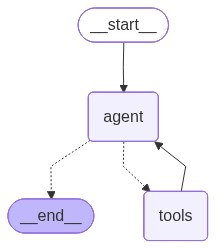

In [28]:
react_agent = create_simple_agent()

from IPython.display import Image, display


display(Image(react_agent.get_graph().draw_mermaid_png()))



- LangGraphÏóêÏÑú Íµ¨ÌòÑÌïú ReAct AgentÎäî ÏïÑÎûòÏôÄ Í∞ôÏùÄ Î™®ÏäµÏùÑ ÌïòÍ≥† ÏûàÏäµÎãàÎã§.
    - "agent"ÎùºÍ≥† Î∂ôÏùÄ LLM **ÎÖ∏Îìú** ÏóêÏÑú ÏÇ¨Ïö©ÏûêÏùò ÏßàÏùòÎ•º Ï≤òÎ¶¨Ìï©ÎãàÎã§.
        - agent ÎÖ∏ÎìúÏóêÏÑúÎäî \_\_end\_\_ ÎÖ∏ÎìúÏôÄ tools ÎÖ∏Îìú Î∞©Ìñ•ÏúºÎ°ú Ìñ•ÌïòÎäî Ï†êÏÑ†Ïùò edgeÍ∞Ä ÏûàÏäµÎãàÎã§. Ïù¥ edgeÍ∞Ä Î∞îÎ°ú conditional edge ÏûÖÎãàÎã§.
            - tools ÌôúÏö©Ïù¥ ÌïÑÏöîÌïòÎ©¥ toolsÎ°ú, Í∑∏Î†áÏßÄ ÏïäÍ≥† ÎãµÎ≥ÄÏùÑ ÎßàÏπ† Ïàò ÏûàÏúºÎ©¥ \_\_end\_\_Î°ú Í∞à Ïàò ÏûàÍ≤å ÎèºÏûàÏäµÎãàÎã§.  

Ïù¥Ï†ú Ïù¥ ReAct AgentÏóê ÏßàÏùòÎ•º ÌïúÎ≤à Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§. 

(Ïö∞ÏÑ† Í∞ÑÎã®ÌïòÍ≤å Î©îÎ™®Î¶¨ Í¥ÄÎ¶¨Î•º ÏúÑÌï¥ LangGraphÏùò `InMemorySaver`Î•º ÏÑ§Ï†ïÌïòÍ≥† `config`Î•º ÏÑ§Ï†ïÌï¥Ï§¨ÏäµÎãàÎã§.)


In [32]:
config = {"configurable": {"thread_id": "1"}}
response = react_agent.invoke(
    {"messages": [{"role": "user", "content": "Ïö∞Î¶¨ ÌöåÏÇ¨ APIÏóê Ï†ëÏÜçÏù¥ Ïûò ÏïàÎêòÎäîÎç∞."}]},
    config  
)
print(response['messages'])

Search with the query: ÌöåÏÇ¨ API Ï†ëÏÜç Î¨∏Ï†ú Ìï¥Í≤∞ Î∞©Î≤ï
[HumanMessage(content='Ïö∞Î¶¨ ÌöåÏÇ¨ APIÏóê Ï†ëÏÜçÏù¥ Ïûò ÏïàÎêòÎäîÎç∞.', additional_kwargs={}, response_metadata={}, id='849d77a9-c9ba-49a6-88bc-290cb87a6582'), AIMessage(content='[API Ï†ëÏÜç Î¨∏Ï†úÎ•º Ìï¥Í≤∞ÌïòÍ∏∞ ÏúÑÌï¥ ÎÇ¥Î∂Ä ÏßÄÏãù Î≤†Ïù¥Ïä§ÏóêÏÑú Í¥ÄÎ†® Ìï¥Í≤∞ Î∞©Î≤ïÏùÑ Í≤ÄÏÉâÌïòÍ≥†, Ï∂îÍ∞ÄÎ°ú ÏõπÏóêÏÑú ÏµúÏã† Ï†ïÎ≥¥Î•º ÌôïÏù∏ÌïòÍ∏∞ ÏúÑÌï¥ Îëê Ìï®ÏàòÎ•º Ìò∏Ï∂úÌñàÏäµÎãàÎã§. ÎÇ¥Î∂Ä ÏßÄÏãù Î≤†Ïù¥Ïä§ÏóêÎäî ÌöåÏÇ¨ ÌäπÏ†ï API Î¨∏Ï†ú Ìï¥Í≤∞ Ï†àÏ∞®Í∞Ä ÏûàÏùÑ Ïàò ÏûàÏúºÎ©∞, Ïõπ Í≤ÄÏÉâÏùÄ ÏùºÎ∞òÏ†ÅÏù∏ API Ï†ëÏÜç Î¨∏Ï†ú Ìï¥Í≤∞ Î∞©Î≤ïÏùÑ Ï†úÍ≥µÌï† Ïàò ÏûàÏñ¥ Îëò Îã§ ÌïÑÏàòÏ†ÅÏûÖÎãàÎã§.]  \n\nÏ∂îÍ∞ÄÎ°ú Îã§Ïùå Ï†ïÎ≥¥Î•º Ï†úÍ≥µÌï¥ Ï£ºÏãúÎ©¥ Îçî Ï†ïÌôïÌïú ÎèÑÏõÄÏùÑ ÎìúÎ¶¥ Ïàò ÏûàÏäµÎãàÎã§:  \n1. Ïñ¥Îñ§ API ÏóîÎìúÌè¨Ïù∏Ìä∏Ïóê Ï†ëÏÜçÌïòÏãúÎ†§Í≥† ÌïòÎÇòÏöî?  \n2. Ïñ¥Îñ§ Ïò§Î•ò Î©îÏãúÏßÄÍ∞Ä ÌëúÏãúÎêòÎÇòÏöî? (Ïòà: 404 Not Found, 500 Internal Server Error Îì±)  \n3. Ï†ëÏÜç ÏãúÎèÑ Ïãú ÏÇ¨Ïö©Ìïú ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏/ÎèÑÍµ¨(Postman, cURL Îì±)ÏôÄ Ïö

In [35]:
## Í≤∞Í≥º ÌôïÏù∏ÏùÑ ÏúÑÌïú Helper Function ÏûÖÎãàÎã§. ##
def pretty_print_conversation(messages):
    """Pretty print conversation flow with detailed step-by-step analysis."""
    
    print("\n" + "="*80)
    print("ÔøΩÔøΩ CONVERSATION FLOW ANALYSIS")
    print("="*80)
    
    step_counter = 1
    
    for i, message in enumerate(messages):
        print(f"\n{'‚îÄ'*60}")
        print(f"üìù STEP {step_counter}: {message.__class__.__name__}")
        print(f"{'‚îÄ'*60}")
        
        if isinstance(message, HumanMessage):
            print(f"üë§ USER INPUT:")
            print(f"   {message.content}")
            
        elif isinstance(message, AIMessage):
            if hasattr(message, 'tool_calls') and message.tool_calls:
                print(f"ü§ñ ASSISTANT DECISION:")
                print(f"   üí≠ Reasoning: {message.content}")
                print(f"\nüîß TOOL CALLS:")
                
                for j, tool_call in enumerate(message.tool_calls):
                    print(f"   {j+1}. Tool: {tool_call['name']}")
                    print(f"      Args: {tool_call['args']}")
                    print(f"      ID: {tool_call['id']}")
            else:
                print(f"ü§ñ ASSISTANT RESPONSE:")
                print(f"   {message.content}")
                
        elif hasattr(message, 'name') and message.name:  # ToolMessage
            print(f"üìö TOOL EXECUTION RESULT:")
            print(f"   Tool: {message.name}")
            print(f"   Call ID: {message.tool_call_id}")
            print(f"   Result:")
            print(f"   {message.content}")
            
        # Show metadata if available
        if hasattr(message, 'response_metadata') and message.response_metadata:
            metadata = message.response_metadata
            if 'token_usage' in metadata:
                tokens = metadata['token_usage']
                print(f"\nÔøΩÔøΩ TOKEN USAGE:")
                print(f"   Input: {tokens.get('prompt_tokens', 0)}")
                print(f"   Output: {tokens.get('completion_tokens', 0)}")
                print(f"   Total: {tokens.get('total_tokens', 0)}")
        
        step_counter += 1
    
    print(f"\n{'='*80}")
    print("‚úÖ CONVERSATION ANALYSIS COMPLETE")
    print("="*80)


def analyze_tool_usage(messages):
    """Analyze tool usage patterns in the conversation."""
    
    print("\n" + "="*60)
    print("üîç TOOL USAGE ANALYSIS")
    print("="*60)
    
    tool_calls = []
    tool_results = []
    
    for message in messages:
        if isinstance(message, AIMessage) and hasattr(message, 'tool_calls') and message.tool_calls:
            for tool_call in message.tool_calls:
                tool_calls.append({
                    'name': tool_call['name'],
                    'args': tool_call['args'],
                    'reasoning': message.content
                })
        elif hasattr(message, 'name') and message.name:
            tool_results.append({
                'name': message.name,
                'result': message.content,
                'call_id': message.tool_call_id
            })
    
    print(f"\nüìä SUMMARY:")
    print(f"   Total Tool Calls: {len(tool_calls)}")
    print(f"   Total Tool Results: {len(tool_results)}")
    
    if tool_calls:
        print(f"\nüîß TOOL CALLS BREAKDOWN:")
        for i, call in enumerate(tool_calls, 1):
            print(f"   {i}. {call['name']}")
            print(f"      Arguments: {call['args']}")
            print(f"      Reasoning: {call['reasoning'][:100]}...")
    
    if tool_results:
        print(f"\nÔøΩÔøΩ TOOL RESULTS BREAKDOWN:")
        for i, result in enumerate(tool_results, 1):
            print(f"   {i}. {result['name']}")
            print(f"      Result Length: {len(result['result'])} characters")
            print(f"      Preview: {result['result'][:100]}...")


ÏïÑÎûò Í≤∞Í≥ºÎ•º ÌÜµÌï¥ ÎåÄÌôîÏùò ÌùêÎ¶ÑÏùÑ ÏÇ¥Ìé¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [37]:
pretty_print_conversation(response['messages'])

# Analyze tool usage
analyze_tool_usage(response['messages'])


ÔøΩÔøΩ CONVERSATION FLOW ANALYSIS

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üìù STEP 1: HumanMessage
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üë§ USER INPUT:
   Ïö∞Î¶¨ ÌöåÏÇ¨ APIÏóê Ï†ëÏÜçÏù¥ Ïûò ÏïàÎêòÎäîÎç∞.

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üìù STEP 2: AIMessage
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
ü§ñ ASSISTANT DECISION:
   üí≠ Reasoning: [API Ï†ëÏÜç Î¨∏Ï†úÎ•º Ìï¥Í≤∞ÌïòÍ∏∞ ÏúÑÌï¥ ÎÇ¥Î∂Ä ÏßÄÏãù Î≤†Ïù¥Ïä§ÏóêÏÑú Í¥ÄÎ†

ÎåÄÌôîÏùò ÎÇ¥Ïö©ÏùÑ ÏÇ¥Ìé¥Î≥¥Î©¥,

> '`search_knowledge_base`Îäî ÌöåÏÇ¨ ÎÇ¥Î∂Ä Í∏∞Ïà† Î¨∏ÏÑúÏóêÏÑú Í≥µÏãù Ìï¥Í≤∞ Î∞©Î≤ïÏùÑ Ï∞æÍ∏∞ ÏúÑÌï¥, `web_search`Îäî ÏùºÎ∞òÏ†ÅÏù∏ API Ï†ëÏÜç Î¨∏Ï†ú Ìï¥Í≤∞ Î∞©Î≤ïÏùÑ Î≥¥ÏôÑÌïòÍ∏∞ ÏúÑÌï¥ Ìò∏Ï∂ú~'

Ïù¥ÎùºÍ≥† LLMÏù¥ ReasoningÌïòÎäî Î∂ÄÎ∂ÑÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

LLMÏùò tool callingÏùÄ Í≤ΩÏö∞Ïóê Îî∞Îùº Îã§ÏñëÌïú Î∞©ÏãùÏúºÎ°ú ÌôúÏö©ÎêòÍ∏∞ÎèÑ ÌïòÍ≥†, ÌäπÏ†ï Î∞©Ìñ•ÏúºÎ°ú Ïª®Ìä∏Î°§ ÌïòÎäî Í≤ÉÏù¥ Í∞ÑÎã®ÌïòÏßÄÎäî ÏïäÏäµÎãàÎã§. Ï†ÄÌù¨Í∞Ä Prompt EnigneeringÏùÑ ÌÜµÌï¥ LLMÏùò ÏûëÎèôÎ∞©ÏãùÏùÑ ÌÜµÏ†úÌïòÎìØÏù¥, Tool CallingÏùò Í≤ΩÏö∞ÏóêÎèÑ

ToolÏùò Ïù¥Î¶Ñ, ToolÏùò ÏÉÅÏÑ∏ÏÑ§Î™ÖÏùÑ Îçî ÏûêÏÑ∏ÌïòÍ≥† ÏÉÅÏÑ∏ÌïòÍ≤å Îã§Îäî Í≤ÉÏúºÎ°ú ÌôïÏù∏ Ìï† Ïàò ÏûàÏäµÎãàÎã§. 

- ToolÏùò Ïù¥Î¶ÑÏùÑ Ïûò ÏßìÎäî Í≤ÉÏù¥ Ï§ëÏöîÌïú Ïù¥Ïú†: [ÎßÅÌÅ¨](https://slashpage.com/sujin-prompt-engineer/prompt_tips?post=d367nxm3qz86jmj98pv1)

## 5.3 ReAct Agent ÏßÅÏ†ë ÎßåÎì§Ïñ¥Î≥¥Í∏∞



Îî∞ÎùºÏÑú Îã§ÏùåÍ≥º Í∞ôÏùÄ Í≥ºÏ†ïÏùÑ Í±∞ÏπòÎ©¥ ReAct AgentÎ•º ÏßÅÏ†ë ÎßåÎì§Ïñ¥Î≥º ÏàòÎèÑ ÏûàÏäµÎãàÎã§.

1. `AgentState`Î•º ÏÑ†Ïñ∏Ìï¥Ï§çÎãàÎã§. Ïù¥ StateÎäî AgentÏùò Ï†ïÎ≥¥Îì§ÏùÑ Í∏∞Î°ùÌïòÎäî Í≥≥ÏûÖÎãàÎã§. Í∞ÑÎã®ÌïòÍ≤å ÎåÄÌôîÏùò ÎÇ¥Ïö©Îßå Í∏∞Î°ùÌïòÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

2. `llm_node`Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§.
    - Ïù¥ Îïå Î™®Îç∏ÏùÄ ÏÑ†Ïñ∏ÌïòÍ≥†, Í∏∞Ï°¥Ïùò Ï†ïÏùòÎêú toolÎì§ÏùÑ ÏÇ¨Ïö©Ìï† Ïàò ÏûàÍ≤å, `model.bind_tools(tools)`ÏùÑ Ìï¥Ï§çÎãàÎã§.

3.  `tool_node`Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§.
    - Î™®Îç∏Ïù¥ tool callingÏùÑ Ìï† Îïå, Î©îÏÑ∏ÏßÄÏóê Îã¥Í≤®ÏûàÎäî "name"Í≥º "args"Î•º ÌôïÏù∏Ìï¥ toolÏùÑ Ïã§Ï†úÎ°ú Ïã§ÌñâÌïòÎäî Ìï®ÏàòÏûÖÎãàÎã§.

Ïù¥Î≤àÏóêÎäî ÎÖ∏ÎìúÎ•º Ïã§Ï†úÎ°ú Íµ¨ÌòÑÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.

- LangGraphÏóêÏÑú ÎÖ∏ÎìúÎäî Ïã§Ï†úÎ°ú ÏûëÏóÖÏù¥ ÏùºÏñ¥ÎÇòÎäî Í≥≥ÏúºÎ°ú, Í∞ÑÎã®ÌïòÍ≤å Python Ìï®ÏàòÎ°ú Íµ¨ÌòÑÎèºÏûàÏäµÎãàÎã§.

    - Ïù¥ Îïå, Ìï®ÏàòÎäî GraphÏùò StateÎ•º ÏûÖÎ†•ÏúºÎ°ú Î∞õÍ≥†, ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú StateÎ•º ÏóÖÎç∞Ïù¥Ìä∏ Ìïú Îã§Ïùå Î∞òÌôòÌïòÎäî ÌòïÌÉúÏûÖÎãàÎã§.

### 5.3.1 AgentState Ï†ïÏùòÌïòÍ∏∞

In [39]:
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

### 5.3.2 LLM ÎÖ∏Îìú Ï†ïÏùòÌïòÍ∏∞

In [42]:
model = ChatUpstage(model="solar-pro2", temperature=0)
tools = [search_knowledge_base, web_search]
model = model.bind_tools(tools)

def llm_node(state: AgentState) -> Dict[str, Any]:
    system = SystemMessage(
        "You are Agent, a concise and helpful support assistant. "
        "Answer using only provided info and be kind."
    )
    resp = model.invoke([system] + state["messages"])
    return {"messages": [resp]}

### 5.3.3 Tool ÎÖ∏Îìú Ï†ïÏùòÌïòÍ∏∞

In [44]:
tools_by_name = {tool.name: tool for tool in tools}

def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


In [45]:
message = AIMessage(
    content="",
    tool_calls=[{
        "name": "search_knowledge_base",
        "args": {"query": 'How can I reset my password?', "top_k": 3},
        "id": "tool_call_id",
        "type": "tool_call"
    }]
)
response = tool_node(state={"messages": [message]})
print(response['messages'][0].content)

[{"content": "To reset your password, go to the login page and click 'Forgot Password'. Enter your email address and check your inbox for reset instructions. The reset link expires in 24 hours.", "score": 0.5518820285797119, "topic": "Password Reset", "category": "Account", "index": 0, "rank": 1}, {"content": "Two-factor authentication (2FA) can be enabled in Security Settings. We support SMS, email, and authenticator apps. 2FA is required for Enterprise accounts and recommended for all users.", "score": 0.3110274374485016, "topic": "Security", "category": "Account", "index": 5, "rank": 2}, {"content": "Data export is available for all plans. Go to Account Settings > Data Export to request your data. The export will be emailed to you within 24 hours and includes all your account data in JSON format.", "score": 0.2634652853012085, "topic": "Data Export", "category": "Account", "index": 4, "rank": 3}]


Ïù¥Ï†ú ReAct Íµ¨Ï°∞Ïóê ÌïµÏã¨Ïù¥ÎùºÍ≥† Ìï† Ïàò ÏûàÎäî LLMÏóêÏÑú toolsÏôÄ \_\_end\_\_Î•º Ï°∞Í±¥Î∂Ä(conditional)Ïó∞Í≤∞ÌïòÎäî Î°úÏßÅÏùÑ ÏûëÏÑ±Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

### 5.3.4 Conditional Edge Ï†ïÏùòÌïòÍ∏∞

`Conditional Edge`Îäî ÌòÑÏû¨ Í∑∏ÎûòÌîÑÏùò ÏÉÅÌÉú (`state`)Î•º ÏûÖÎ†•ÏúºÎ°ú Î∞õÏïÑ Îã§ÏùåÏóê Ïñ¥Îäê Í≤ÉÏúºÎ°ú Ìñ•Ìï† ÏßÄ ÏïåÎ†§Ï£ºÎäî Python Ìï®ÏàòÏûÖÎãàÎã§.

`tool_calling`ÏùÑ Ìï† ÏßÄ, ÎãµÎ≥ÄÏùÑ ÏÉùÏÑ±Ìï† ÏßÄÏóê ÎåÄÌï¥ÏÑúÎäî Îã§ÏùåÍ≥º Í∞ôÏùÄ Î°úÏßÅÏúºÎ°ú ÌôïÏù∏Ïù¥ Í∞ÄÎä•Ìï©ÎãàÎã§:

1. stateÏóê Îã¥Í≥†ÏûàÎäî `messages`Î•º Í∞ÄÏû• ÏµúÍ∑º Î©îÏÑ∏ÏßÄÎ•º ÌôïÏù∏ÌñàÏùÑ Îïå, tool_calls Í∞Ä ÏûàÏúºÎ©¥ tool calling
2. Í∑∏Î†áÏßÄ ÏïäÏúºÎ©¥ "end"Î°ú!

ÏúÑÏùò Î°úÏßÅÏùÑ Îã§ÏùåÍ≥º Í∞ôÏù¥ Íµ¨ÌòÑÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.

In [46]:
def tool_call_or_end(state: AgentState):

    messages = state["messages"]
    last_message = messages[-1]
    
    if not last_message.tool_calls:
        return "end"
    else:
        return "tool_call_needed"


Ïù¥Ï†ú Ïù¥ Conditional EdgeÏôÄ Ìï®Íªò Í∑∏ÎûòÌîÑÎ•º ÎßåÎì§Ïñ¥Î≥¥Í≤†ÏäµÎãàÎã§.

### 5.3.5 ReAct Í∑∏ÎûòÌîÑ ÎπåÎìúÌïòÍ∏∞

In [48]:
builder = StateGraph(AgentState)
builder.add_node("llm", llm_node) # NodeÎ•º ÎçîÌï† ÎïåÎäî "ÎÖ∏ÎìúÏùò Ïù¥Î¶Ñ", Ìï®Ïàò ÌòïÌÉúÎ°ú ÏÑ†Ïñ∏Ìï©ÎãàÎã§.
builder.add_node("tools", tool_node)
builder.set_entry_point("llm")


builder.add_conditional_edges(
    # ÏãúÏûëÏ†êÏùÑ "llm" ÏúºÎ°ú ÏÑ†Ï†ïÌï¥Ï§çÎãàÎã§.
    "llm",
    # Î∂ÑÍ∏∞ Ï°∞Í±¥Ïóê Ìï¥ÎãπÌïòÎäî Ìï®ÏàòÎ•º ÎÑ£Ïñ¥Ï§çÎãàÎã§.
    tool_call_or_end,
    # ÎßàÏßÄÎßâÏúºÎ°ú return ÎêòÎäî Í∞íÏóê Îî∞Îùº Ïñ¥ÎîîÎ°ú Ìñ•Ìï† ÏßÄÎ•º Ï†ïÌï¥Ï§çÎãàÎã§.
    # "end"Ïù∏ Í≤ΩÏö∞ Í∑∏ÎûòÌîÑÎ•º Ï¢ÖÎ£åÌïòÎäî Í≥≥ÏúºÎ°ú
    # "tool_call_needed"Ïù∏ Í≤ΩÏö∞ "tools"Î°ú Ìñ•ÌïòÍ≤å Îê©ÎãàÎã§.
    {
        # If `tools`, then we call the tool node.
        "tool_call_needed": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# tools ÎÖ∏ÎìúÏóêÏÑú ÎÇòÏò® Í≤∞Í≥ºÎäî Îã§Ïãú llm ÎÖ∏ÎìúÎ°ú Ìñ•ÌïòÍ≤å Îê©ÎãàÎã§.
builder.add_edge("tools", "llm")


graph = builder.compile()


from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [49]:
for chunk in graph.stream(
    {"messages": [("human", "How can I reset my password?")]},
    stream_mode="values",
):
    # ÎßàÏßÄÎßâ Î©îÏãúÏßÄ Ï∂úÎ†•
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

How can I reset my password?
================================== Ai Message ==================================

To reset your password, you can typically follow these general steps (no function calls needed as this is standard procedure):

1. Go to the login page of the service you're using
2. Click "Forgot Password" or similar link
3. Enter your registered email address
4. Check your email for a password reset link
5. Click the link and follow instructions to create a new password

If you need specific instructions for a particular service, please let me know which one you're referring to, and I can provide more detailed guidance. 

No function calls are needed since this is general knowledge about password reset processes.


## 5.4 Build Comprehensive Workflow

- ÏßÄÍ∏àÍπåÏßÄÎäî Í∞ÑÎã®ÌïòÍ≤å ReAct AgentÎ°ú Í≥†Í∞ù ÏùëÎåÄ ÌïòÎäî ÏóêÏù¥Ï†ÑÌä∏Î•º ÎßåÎì§Ïñ¥Î¥§ÏäµÎãàÎã§.
- Ïù¥ ÏóêÏù¥Ï†ÑÌä∏Î•º Îçî Í∞úÏÑ†Îêú ÌòïÌÉúÎ°ú ÎßåÎìúÎ†§Î©¥ Ïñ¥Îñ§ Î∞©Î≤ïÏù¥ ÏûàÏùÑÍπåÏöî?
    - Ïö∞ÏÑ† ÌòÑÏû¨Îäî StateÏóê ÎåÄÌôîÎÇ¥Ïö©Îßå Í∏∞Î°ùÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïù¥Îü∞ Íµ¨Ï°∞Î≥¥Îã§Îäî StateÏóê Í≥†Í∞ùÏùò id, Í≥†Í∞ùÏùò Ï†ïÎ≥¥, Í≥†Í∞ùÏùò ÏßàÎ¨∏ÏùÑ Îî∞Î°ú Í¥ÄÎ¶¨ÌïòÎäî Í≤ÉÏù¥ Îçî Ï¢ãÏùÑ Ïàò ÏûàÏäµÎãàÎã§.
    
    - ÎòêÌïú ToolÏùÑ ÏÇ¨Ïö©ÌñàÏùÑ ÎïåÏùò Í≤∞Í≥ºÎèÑ Îî∞Î°ú Ï†ÄÏû•ÏùÑ Ìï¥ÎëêÎ©¥, ÌäπÏ†ï Î∂ÑÍ∏∞Î•º ÌïòÎäî Í≥ºÏ†ïÏóêÏÑú ÏöîÍ∏¥ÌïòÍ≤å Ïì∏ ÏàòÎèÑ ÏûàÏäµÎãàÎã§. ÏòàÎ•º Îì§Ïñ¥, Î¨∏ÏÑú Í≤ÄÏÉâÏùÑ Ìï¥ÏÑú Ï†ïÎ≥¥Îäî Í∞ÄÏ†∏ÏôîÏßÄÎßå Ïú†ÏÇ¨ÎèÑÍ∞Ä ÎßéÏù¥ ÎÇÆÎã§Î©¥ Îã§Î•∏ Î∂ÑÍ∏∞Î•º Ìï† ÏàòÎèÑ ÏûàÏäµÎãàÎã§.

    - ÏóêÏù¥Ï†ÑÌä∏Ïùò ÌòïÌÉú ÏûêÏ≤¥ÎèÑ ÏÉàÎ°ú ÏÉùÍ∞ÅÌï† Ïàò ÏûàÏäµÎãàÎã§.
        - Ïú†Ï†ÄÏùò Ï†ïÎ≥¥ÏôÄ ÏßàÎ¨∏ÏùÑ `llm` ÎÖ∏ÎìúÎ°ú Ìñ•ÌïòÍ∏∞ Ï†ÑÏóê ÎØ∏Î¶¨ ÏûÖÎ†•ÏùÑ Î∞õÏùÑ Ïàò ÏûàÏäµÎãàÎã§.
        - `llm`Ïù¥ `tools`ÏóêÏÑú ÎãµÎ≥ÄÏùÑ Î∞õÏùÄ Îí§ ÎãµÎ≥ÄÏùÑ ÏÉùÏÑ±ÌïòÍ∏∞ Ï†ÑÏóê **ÌïúÎ≤àÏùò Î∂ÑÍ∏∞**Î•º Ï∂îÍ∞ÄÌïòÏó¨
            - Ïù¥ `tools`ÏóêÏÑú Î∞õÏùÄ Í≤∞Í≥ºÍ∞Ä ÏñºÎßàÎÇò **Ìö®Í≥ºÏ†ÅÏù∏ÏßÄ** ÌåêÎã®Ìïú ÌõÑÏóê
                1. Ìö®Í≥ºÏ†ÅÏù¥ÏßÄ ÏïäÎã§Î©¥, Îã¥ÎãπÏûêÏóêÍ≤å Ï†ÑÎã¨ÌïòÍ±∞ÎÇò
                2. Ìö®Í≥ºÏ†ÅÏù¥ÎùºÎ©¥, ÎãµÎ≥ÄÏùÑ ÏÉùÏÑ±ÌïòÍ≥† ÎßàÏπ† Ïàò ÏûàÏäµÎãàÎã§.

Ïù¥Îü∞ ÏãùÏúºÎ°ú ÏóêÏù¥Ï†ÑÌä∏Î•º Íµ¨ÏÑ±ÌïòÎäî Í≤ÉÏùÄ Ïã§Ï†ú ÏóÖÎ¨¥Ïùò ÌùêÎ¶ÑÏóê Ìï¥ÎãπÌïòÎäî WorkflowÎ•º ÏÉÅÏÑ∏ÌïòÍ≤å Íµ¨ÌòÑÌïòÍ≥† Ìï¥Îãπ Î°úÏßÅÏùÑ Ï†ïÍµêÌïòÍ≤å ÏÑ§Í≥ÑÌïòÎäî ÏùºÏù¥ÎùºÍ≥† Î≥º Ïàò ÏûàÏäµÎãàÎã§.

1. Ïö∞ÏÑ† ÏúÑÏóêÏÑú toolÏùÑ ÎßåÎì§ÏóàÎçò Î∞©ÏãùÍ≥º ÎèôÏùºÌïòÍ≤å `fetch_customer_data` toolÏùÑ ÎßåÎì§Ïñ¥Î≥¥Í≤†ÏäµÎãàÎã§.
    - Ïù¥Î≤à Ïã§ÏäµÏóêÏÑúÎäî ÏúÑÏóêÏÑú Íµ¨ÌòÑÌïú `load_customer_data`Î•º ÌÜµÌï¥ Îç∞Î™® Îç∞Ïù¥ÌÑ∞ (`csv`)Î•º ÎîïÏÖîÎÑàÎ¶¨ ÌòïÌÉúÎ°ú Î≥ÄÌôòÌï¥ÏÑú Îç∞Ïù¥ÌÑ∞ ÌòïÌÉúÎ°ú Í∞ÄÏßÄÍ≥† ÏûàÏäµÎãàÎã§!

### 5.4.1 GraphState Ï†ïÏùòÌïòÍ∏∞


Ïö∞ÏÑ† ÏúÑÏóêÏÑú ÏÉùÍ∞ÅÌï¥ Î≥∏ ÏõåÌÅ¨ÌîåÎ°úÏö∞Î•º ÌÜ†ÎåÄÎ°ú AgentÍ∞Ä Îì§Í≥† Í∞à Ï†ïÎ≥¥Î•º Îã§ÏùåÍ≥º Í∞ôÏù¥ Ï∂îÎ¶¥ Ïàò ÏûàÏäµÎãàÎã§.
- customer_question: str
    - ÏÇ¨Ïö©ÏûêÏùò ÏßàÎ¨∏ÏùÑ str ÌòïÌÉúÎ°ú Ï†ÄÏû•Ìï©ÎãàÎã§.
- customer_id: str
    - ÏÇ¨Ïö©ÏûêÏùò idÎ•º str ÌòïÌÉúÎ°ú Ï†ÄÏû•Ìï©ÎãàÎã§.
- customer_context: str
    - ÏÇ¨Ïö©ÏûêÏùò Ï†ïÎ≥¥Î•º str ÌòïÌÉúÎ°ú Ï†ÄÏû•Ìï©ÎãàÎã§.
- knowledge_base_results: List[Dict[str, Any]]
    - knowledge_base_searchÏùò Í≤∞Í≥ºÎ•º ÎîïÏÖîÎÑàÎ¶¨Í∞Ä Îã¥Í∏¥ Î¶¨Ïä§Ìä∏ ÌòïÌÉúÎ°ú Ï†ÄÏû•Ìï©ÎãàÎã§.
- web_search_raw_results: List[Dict[str, Any]]
    - web_searchÏùò Í≤∞Í≥ºÎ•º ÎîïÏÖîÎÑàÎ¶¨Í∞Ä Îã¥Í∏¥ Î¶¨Ïä§Ìä∏ ÌòïÌÉúÎ°ú Ï†ÄÏû•Ìï©ÎãàÎã§.
- specialist_info: Dict[str, Any]
    - Îã¥ÎãπÏûê(specialist)Ïùò Ï†ïÎ≥¥Î•º ÎîïÏÖîÎÑàÎ¶¨Î°ú Ï†ÄÏû•Ìï©ÎãàÎã§.
- messages: Annotated[List[BaseMessage], add_messages]
    - messagesÎ•º Í∏∞Î°ùÌïòÍ≥† langgraphÏùò `add_messages` ReducerÎ•º ÏÇ¨Ïö©Ìï¥ ÏûêÎèôÏúºÎ°ú Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞ÄÎêòÎèÑÎ°ù Ï†ÄÏû•Ìï©ÎãàÎã§.

ÏúÑÏùò Ï†ïÎ≥¥Îì§ÏùÑ Í∏∞Î°ùÌïòÎäî GraphStateÎ•º Ïö∞ÏÑ† ÎßåÎì§Ïñ¥Î≥¥Í≤†ÏäµÎãàÎã§.

In [51]:
class GraphState(TypedDict):
    customer_question: str
    customer_id: str
    customer_context: str
    knowledge_base_results: List[Dict[str, Any]]
    web_search_raw_results: List[Dict[str, Any]] 
    specialist_info: Dict[str, Any]
    messages: Annotated[List[BaseMessage], add_messages]

### 5.4.2 get_customer_id, get_customer_question Ï†ïÏùòÌïòÍ∏∞

- GraphStateÏóêÏÑú Í≥†Í∞ùÏùò id, Í≥†Í∞ùÏùò Ï†ïÎ≥¥, Í≥†Í∞ùÏùò ÏßàÎ¨∏ÏùÑ Îî∞Î°ú Í¥ÄÎ¶¨ÌïòÍ∏∞Î°ú ÌñàÏäµÎãàÎã§. 

- Ïù¥ Î∂ÄÎ∂ÑÏùÄ ÏÇ¨Ïö©ÏûêÏóêÍ≤å ÏßÅÏ†ë idÎ•º ÏûÖÎ†•Î∞õÏïÑ Ï†ïÎ≥¥Î•º Í∞ÄÏ†∏Ïò§Í≥†, Í∑∏ Îã§Ïùå ÏßàÎ¨∏ÏùÑ ÏûÖÎ†•Î∞õÏïÑ ÏßàÎ¨∏ÏùÑ Í¥ÄÎ¶¨ÌïòÎäî Î°úÏßÅÏúºÎ°ú ÏÉùÍ∞ÅÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.

    - Ïã§Ï†úÎ°ú ÏÑúÎπÑÏä§Î•º Ìï† ÎïåÎäî ÏÇ¨Ïö©ÏûêÍ∞Ä Ïù¥ÎØ∏ Î°úÍ∑∏Ïù∏ÏùÑ Ìïú ÏÉÅÌÉúÎùºÎ©¥ Í∑∏ ÎïåÏùò Ï†ïÎ≥¥Î•º Í∞ÄÏßÄÍ≥† Ïò§ÎèÑÎ°ù ÌôúÏö©Ìï† ÏàòÎèÑ ÏûàÏäµÎãàÎã§!

In [55]:
# Section1ÏóêÏÑú Ï†ïÏùòÌïú customers
print(customers)

{'CUST001': {'customer_id': 'CUST001', 'name': 'ÍπÄÎØºÏ§Ä', 'email': 'kim.minjun@email.com', 'plan': 'Premium', 'subscription_status': 'active', 'last_login': '2024-01-15', 'account_age_days': 365, 'previous_issues': 2}, 'CUST002': {'customer_id': 'CUST002', 'name': 'Ïù¥ÏÑúÏó∞', 'email': 'lee.seoyeon@company.com', 'plan': 'Basic', 'subscription_status': 'active', 'last_login': '2024-01-14', 'account_age_days': 180, 'previous_issues': 0}, 'CUST003': {'customer_id': 'CUST003', 'name': 'Î∞ïÏßÄÌõà', 'email': 'park.jihoon@tech.com', 'plan': 'Enterprise', 'subscription_status': 'active', 'last_login': '2024-01-13', 'account_age_days': 730, 'previous_issues': 5}, 'CUST004': {'customer_id': 'CUST004', 'name': 'ÏµúÏàòÎπà', 'email': 'choi.subin@startup.io', 'plan': 'Premium', 'subscription_status': 'expired', 'last_login': '2024-01-10', 'account_age_days': 90, 'previous_issues': 1}, 'CUST005': {'customer_id': 'CUST005', 'name': 'Ï†ïÌïòÏùÄ', 'email': 'jung.haeun@corp.com', 'plan': 'Basic', 'subsc

In [56]:
def fetch_customer_data(customer_id: str) -> str:
    """Fetch customer data from CRM system."""
    try:
        customer_data = customers.get(customer_id, {})
        
        if not customer_data:
            return "No customer data found for this ID."
        
        context_parts = []
        if customer_data.get('name'):
            context_parts.append(f"Name: {customer_data['name']}")
        if customer_data.get('email'):
            context_parts.append(f"Email: {customer_data['email']}")
        if customer_data.get('plan'):
            context_parts.append(f"Plan: {customer_data['plan']}")
        if customer_data.get('subscription_status'):
            context_parts.append(f"Status: {customer_data['subscription_status']}")
        if customer_data.get('account_age_days'):
            context_parts.append(f"Account Age: {customer_data['account_age_days']} days")
        if customer_data.get('previous_issues'):
            context_parts.append(f"Previous Issues: {customer_data['previous_issues']}")
        
        customer_context = "Customer Information:\n" + "\n".join(context_parts)
        # print(f"‚úÖ Customer context retrieved for {customer_id}")
        return customer_context
        
    except Exception as e:
        return f"‚ùå Customer data fetch error: {str(e)}"

In [57]:
print(fetch_customer_data("CUST001"))

Customer Information:
Name: ÍπÄÎØºÏ§Ä
Email: kim.minjun@email.com
Plan: Premium
Status: active
Account Age: 365 days
Previous Issues: 2


ÏúÑ Ìï®ÏàòÎ•º Î∞îÌÉïÏúºÎ°ú Îëê ÎÖ∏Îìú, `get_customer_id`ÏôÄ `get_customer_question`Î•º ÎßåÎì§Ïñ¥Î≥¥Í≤†ÏäµÎãàÎã§.

Ïù¥ ÎïåÎäî langgraphÏùò `interrupt`Î•º ÌôúÏö©Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§. `interrupt`Îäî Îßê Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©ÏûêÍ∞Ä Í∞úÏûÖÌï¥ ÌäπÏ†ï Ïï°ÏÖòÏùÑ ÌïòÎèÑÎ°ù ÏûÖÎ†•ÏùÑ Ï£ºÎäî Í≤ÉÏúºÎ°ú PythonÏóêÏÑúÏùò `input()`Í≥º ÎπÑÏä∑Ìïú Ïó≠Ìï†Ïù¥ÎùºÍ≥† Î≥º Ïàò ÏûàÏäµÎãàÎã§.

In [ ]:
def get_customer_id(state: GraphState) -> Dict[str, Any]:
    """Get customer ID from user."""
    customer_id = interrupt("üÜî Welcome to Customer Support! Can you please enter your Customer ID (CUSTXXX format)?") # ÏÇ¨Ïö©ÏûêÏóêÍ≤å Customer IDÎ•º ÏûÖÎ†•Î∞õÏäµÎãàÎã§.
    
    # Validate customer ID format
    if not customer_id or not customer_id.startswith("CUST"):
        customer_id = interrupt(f"‚ùå Invalid format '{customer_id}'. Please enter your Customer ID in CUSTXXX format:")
    
    customer_context = fetch_customer_data(customer_id)
    print(f"‚úÖ Customer context retrieved for {customer_id}")
    print(f"‚úÖ Customer context: {customer_context}")
    return {"customer_id": customer_id, "customer_context": customer_context}

def get_customer_question(state: GraphState) -> Dict[str, Any]:
    """Get customer question from user."""
    customer_question = interrupt("‚ùì Do you need any help? Please describe your issue or question:") # ÏÇ¨Ïö©ÏûêÏóêÍ≤å ÏßàÎ¨∏ÏùÑ ÏûÖÎ†•Î∞õÏäµÎãàÎã§.
    
    if not customer_question or len(customer_question.strip()) < 5:
        customer_question = interrupt("‚ùì Please provide more details about your issue:")
    
    return {"customer_question": customer_question}

** ÏúÑÏóêÏÑú Í∞ÑÎã®ÌïòÍ≤å Íµ¨ÌòÑÌïú get_customer_idÏóê Î©ÄÌã∞ÌÑ¥Ïù¥ Í∞ÄÎä•ÌïòÎèÑÎ°ù Îã§ÏñëÌïú Î°úÏßÅÏùÑ Ï∂îÍ∞ÄÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.**

- Ïã§Ï†ú ÏÑúÎπÑÏä§ÏôÄÎäî Îã§Î•º Ïàò ÏûàÏßÄÎßå Îã§ÏùåÏùò Í≤ΩÏö∞Îì§ÏùÑ Ï≤òÎ¶¨Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.


* 1. Í≥†Í∞ù ID ÌòïÏãù Í≤ÄÏ¶ù (`if not customer_id ...`)
    * ÏóêÎü¨ Î©îÏãúÏßÄÏôÄ Ìï®Íªò Ïû¨ÏûÖÎ†•ÏùÑ ÏöîÏ≤≠.

* 2. ÎåÄÌôî ÏÉÅÌÉú Í¥ÄÎ¶¨ (`if/elif/else`)
    1. `if ...` (Ïù¥Ï†Ñ Í≥†Í∞ùÍ≥º IDÍ∞Ä Îã§Î•∏ Í≤ΩÏö∞)
        * Îã§Î•∏ Í≥†Í∞ùÏù¥ÎØÄÎ°ú, Ïù¥Ï†Ñ ÎåÄÌôî Í∏∞Î°ù(Í≤ÄÏÉâ Í≤∞Í≥º, ÏßàÎ¨∏ Îì±)ÏùÑ **Ï†ÑÎ∂Ä Ï¥àÍ∏∞Ìôî**.
    2. `elif ...` (Ïù¥Ï†Ñ Í≥†Í∞ù IDÍ∞Ä ÏóÜÎäî ÏÉàÎ°úÏö¥ ÏÑ∏ÏÖò)
        * Ï≤´ ÎåÄÌôîÏù¥ÎØÄÎ°ú, Î™®Îì† ÏÉÅÌÉú Î≥ÄÏàòÎ•º **Íπ®ÎÅóÌïòÍ≤å Ï¥àÍ∏∞Ìôî**.
    3. `else` (Ïù¥Ï†Ñ Í≥†Í∞ùÍ≥º IDÍ∞Ä Í∞ôÏùÄ Í≤ΩÏö∞)
        * ÎèôÏùº Í≥†Í∞ùÏùò ÏÉà ÏßàÎ¨∏ÏúºÎ°ú Í∞ÑÏ£ºÌïòÍ≥†, Í≥†Í∞ù Ï†ïÎ≥¥Îäî Ïú†ÏßÄÌïòÎêò **Ïù¥Ï†Ñ Í≤ÄÏÉâ Í≤∞Í≥ºÎßå Ï¥àÍ∏∞Ìôî**.

In [59]:

def get_customer_id(state: GraphState) -> Dict[str, Any]:
    """Get customer ID from user."""
    customer_id = interrupt("üÜî Welcome to Customer Support! Can you please enter your Customer ID (CUSTXXX format)?")
    
    # Validate customer ID format
    if not customer_id or not customer_id.startswith("CUST"):
        customer_id = interrupt(f"‚ùå Invalid format '{customer_id}'. Please enter your Customer ID in CUSTXXX format:")
    
    # Check if customer has changed - if so, reset search results
    previous_customer_id = state.get("customer_id", "")
    update_dict = {"customer_id": customer_id}
    
    if previous_customer_id and previous_customer_id != customer_id:
        print(f"üîÑ Customer changed from {previous_customer_id} to {customer_id} - resetting search results")
        update_dict.update({
            "knowledge_base_results": [],
            "web_search_raw_results": [],
            "specialist_info": {},
            "customer_question": ""  # Reset previous question too
        })
    elif not previous_customer_id:
        print(f"üÜï New session for customer {customer_id}")
        # Initialize empty results for new session
        update_dict.update({
            "knowledge_base_results": [],
            "web_search_raw_results": [],
            "specialist_info": {},
            "customer_question": ""
        })
    else:
        print(f"üîÑ Same customer {customer_id} - keeping existing context but resetting search results for new question")
        # Even for same customer, reset search results for new question
        update_dict.update({
            "knowledge_base_results": [],
            "web_search_raw_results": [],
            "specialist_info": {},
            "customer_question": ""
        })
    
    # Fetch customer context
    customer_context = fetch_customer_data(customer_id)
    update_dict["customer_context"] = customer_context
    
    print(f"‚úÖ Customer context retrieved for {customer_id}")
    print(f"‚úÖ Customer context: {customer_context}")
    
    return update_dict

### 5.4.3 tool_node Ï†ïÏùòÌïòÍ∏∞


tool_nodeÎ•º Î®ºÏ†Ä Ï†ïÏùòÌï¥Î≥¥Í≤†ÏäµÎãàÎã§. GraphStateÏóêÏÑú Ï†ïÏùòÌïúÎåÄÎ°ú `knowledge_base_results`ÏôÄ `web_search_raw_results`Î•º Í∞ÅÍ∞Å Ìà¥ÏùÑ ÏÇ¨Ïö©Ìï† ÎïåÎßàÎã§ ÏóÖÎç∞Ïù¥Ìä∏ Ìï¥Ï§Ñ ÏòàÏ†ïÏù¥Í∏∞ ÎïåÎ¨∏Ïóê

tool_nodeÎ•º Íµ¨ÌòÑÌï† Îïå Ìï¥Îãπ Î°úÏßÅÎèÑ Ìï®Íªò ÎÑ£Ïñ¥Ï£ºÍ≤†ÏäµÎãàÎã§.

In [60]:
tools = [search_knowledge_base, web_search]

tools_by_name = {tool.name: tool for tool in tools}

def tool_node(state: GraphState) -> Dict[str, Any]:
    """Execute tools and update state with structured results."""
    
    outputs = []
    update = {"messages": []}
    
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = None
        for tool in tools:
            if tool.name == tool_call["name"]:
                tool_result = tool.invoke(tool_call["args"])
                break
        
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result) if tool_result else "Tool not found",
                tool_call_id=tool_call["id"],
            )
        )
        
        if tool_call["name"] == "search_knowledge_base": # tool_callÏù¥ search_knowledge_baseÏù∏ Í≤ΩÏö∞
            kb_results = tool_result if isinstance(tool_result, list) else []
            update["knowledge_base_results"] = kb_results # knowledge_base_resultsÎ•º ÏóÖÎç∞Ïù¥Ìä∏ Ìï¥Ï§çÎãàÎã§.
            print(f"üìö KB search completed with {len(kb_results)} results")
        
        if tool_call["name"] == "web_search": # tool_callÏù¥ web_searchÏù∏ Í≤ΩÏö∞
            web_results = tool_result if isinstance(tool_result, list) else []
            update["web_search_raw_results"] = web_results # web_search_raw_resultsÎ•º ÏóÖÎç∞Ïù¥Ìä∏ Ìï¥Ï§çÎãàÎã§.
            print(f"üåê Web search completed with {len(web_results)} results")
    
    update["messages"] = outputs # ÏúÑÏóêÏÑú Ï†ïÏùòÌïú outputsÎ•º ÏóÖÎç∞Ïù¥Ìä∏ Ìï¥Ï§çÎãàÎã§.
    return update

### 5.4.4 LLM ÎÖ∏Îìú Ï†ïÏùòÌïòÍ∏∞

ÏúÑÏóêÏÑú Í∞ÑÎã®ÌïòÍ≤å Ïù¥Ï†Ñ messageÎ•º Î≥¥Î©¥ÏÑú ÎåÄÎãµÌïòÎäî ÌòïÌÉúÏôÄ Îã¨Î¶¨, Ïù¥Î≤àÏóî Ï†ÄÏû•ÎèºÏûàÎäî Ïª®ÌÖçÏä§Ìä∏Î•º ÌôúÏö©Ìï¥ llm_nodeÎ•º Íµ¨ÌòÑÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.

1. Ïö∞ÏÑ† `customer_id`ÏôÄ `customer_question`ÏùÑ StateÏóêÏÑú Í∞ÄÏ†∏ÏòµÎãàÎã§.
    - Ïù¥Î•º ÌÜµÌï¥ customerÏóê ÎåÄÌïú Ï†ïÎ≥¥, `customer_context`Î•º ÏñªÏùÑ Ïàò ÏûàÏäµÎãàÎã§.
2. LLMÏùò ÏûëÎèôÎ∞©ÏãùÏùÑ Îëê Í∞ÄÏßÄÎ°ú ÎÇòÎàÑÍ≤†ÏäµÎãàÎã§.
    1. Ïö∞ÏÑ† Í∞ÄÏû• Ï≤òÏùå LLMÏù¥ ÏûëÎèôÌï† ÎïåÎäî Ïú†Ï†ÄÏùò Id, Ï†ïÎ≥¥ Í∑∏Î¶¨Í≥† ÌôúÏö©Ìï† Ïàò ÏûàÎäî Ìà¥Ïùò Ï†ïÎ≥¥Î•º Î∞îÌÉïÏúºÎ°ú ÌåêÎã®ÏùÑ Ìï©ÎãàÎã§.
    2. ÎßåÏïΩ `tool_node`ÏóêÏÑú Ìà¥Ïóê ÎåÄÌïú Í≤∞Í≥ºÎ•º Î∞õÏïÑ Ïò® Í≤ΩÏö∞, Ïù¥ tool_nodeÏóêÏÑú ÏóÖÎç∞Ïù¥Ìä∏ Îêú contextÎ•º Î∞îÌÉïÏúºÎ°ú ÎãµÎ≥ÄÏùÑ Ìï©ÎãàÎã§.

Î≥µÏû°Ìï¥Î≥¥Ïù¥ÏßÄÎßå Îëê Í∞ÄÏßÄ Í≤ΩÏö∞Î°ú ÎÇòÎàà Îí§, Í∞ÅÍ∞Å ÌïÑÏöîÌïú Í∞íÏùÑ stateÏóêÏÑú Í∞ÄÏ†∏ÏôÄ promptÏóê ÎÑ£Ïñ¥Ï£ºÎäî Í∞ÑÎã®Ìïú Î∞©ÏãùÏúºÎ°ú Íµ¨ÌòÑÌï† Ïàò ÏûàÏäµÎãàÎã§.

In [61]:
builder = StateGraph(GraphState)
model = ChatUpstage(model="solar-pro2", temperature=0)
model_with_tools = model.bind_tools(tools)


def llm_node(state: GraphState) -> Dict[str, Any]:
    """Main LLM node that processes customer requests and calls tools."""
    customer_id = state.get("customer_id", "Unknown")
    customer_question = state.get("customer_question", "")
            
        # Get customer context
    customer_context = state.get("customer_context", "No customer context available")
    
    print(f"ü§ñ Processing question for {customer_id}: {customer_question[:100]}...")
    
    # Check if we have tool results by looking at state fields directly
    kb_results = state.get("knowledge_base_results", [])
    web_results = state.get("web_search_raw_results", [])
    has_tool_results = len(kb_results) > 0 or len(web_results) > 0
    
    if has_tool_results:
        print("We have tool results")

        
        # Format knowledge base results
        kb_context = ""
        if kb_results:
            kb_formatted = []
            for result in kb_results:
                if isinstance(result, dict) and 'content' in result:
                    topic = result.get('topic', 'Unknown')
                    category = result.get('category', 'Unknown')
                    content = result.get('content', '')
                    score = result.get('score', 0.0)
                    kb_formatted.append(f"- [{category} - {topic}] (Score: {score:.1%}): {content}")
            kb_context = "\n".join(kb_formatted)
        
        # Format web search results
        web_context = ""
        if web_results:
            web_formatted = []
            for result in web_results:
                if isinstance(result, dict) and 'content' in result:
                    title = result.get('title', 'Untitled')
                    content = result.get('content', '')
                    url = result.get('url', '')
                    score = result.get('score', 0.0)
                    web_formatted.append(f"- [{title}] (Score: {score:.1%}): {content}\n  Source: {url}")
            web_context = "\n".join(web_formatted)
        
        # Construct comprehensive system prompt with all context
        system_prompt = f"""You are a Customer Service Assistant helping customer {customer_id}.

CUSTOMER CONTEXT:
{customer_context}

AVAILABLE INFORMATION:"""
        
        if kb_context:
            system_prompt += f"""

KNOWLEDGE BASE RESULTS:
{kb_context}"""
        
        if web_context:
            system_prompt += f"""

WEB SEARCH RESULTS:
{web_context}"""
        
        system_prompt += f"""

CUSTOMER QUESTION: {customer_question}

INSTRUCTIONS:
Use the above information to provide a comprehensive, helpful answer to the customer's question. 
Reference the relevant information from the search results and consider the customer's context.
Be specific and cite the sources when appropriate.
Do NOT call any tools - provide your final answer based on the available information."""

        system = SystemMessage(system_prompt)
        
    else:
        print("First pass: LLM decides whether to use tools or answer directly")
        # First pass: LLM decides whether to use tools or answer directly
        system = SystemMessage(
            f"You are a Customer Service Assistant helping customer {customer_id}.\n"
            f"Customer context: {customer_context}\n"
            f"Available tools: search_knowledge_base, web_search.\n\n"
            f"Customer question: '{customer_question}'\n\n"
            f"Instructions:\n"
            f"1. If you can fully answer this question with your knowledge, provide a complete, helpful response.\n"
            f"2. If you need specific information, call the appropriate tools to gather information.\n"
            f"3. If you cannot help or the request is beyond your capabilities, clearly state: 'I cannot help with this and need to escalate this to a specialist.'"
        )
    
    print(f"üîß System message: {system.content[:200]}...")
    print(f"üìä Tool results available: KB={len(kb_results)}, Web={len(web_results)}")
    
    # For tool results case, we have all context in system prompt, so just pass customer question
    # For first pass, we need the model to potentially call tools
    response = model_with_tools.invoke([system, HumanMessage(content=customer_question)])
    
    return {
        "messages": [response]
    }

### 5.4.5 Conditional Edge Ï†ïÏùòÌïòÍ∏∞

Î∂ÑÍ∏∞ Ï≤òÎ¶¨Î•º ÏúÑÌï¥ `tools_condition` ÏùÑ Ï†ïÏùòÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.
Ïù¥Ï†ÑÏóê Îëê Í≥≥ÏúºÎ°ú ÎÇòÎâòÏóàÎçò Í≤ÉÍ≥º Îã¨Î¶¨ Ïù¥Î≤àÏóêÎäî ÏÑ∏ Í≥≥Ïùò ÎÖ∏ÎìúÎ°ú Ìñ•ÌïòÎäî `tools_condition`ÏùÑ Íµ¨ÌòÑÌïòÍ≤†ÏäµÎãàÎã§.

1. "tools": ÎèÑÍµ¨ ÏÇ¨Ïö©Ïù¥ ÌïÑÏöîÌï† Îïå

2. "end": ÎãµÎ≥ÄÏùÑ ÎÇº Ïàò ÏûàÏùÑ Îïå

3. "escalate_to_specialist": Ï†ÑÎ¨∏Í∞ÄÏùò ÎèÑÏõÄÏù¥ ÌïÑÏöîÌï† Îïå
    - ToolÏùÑ ÏÇ¨Ïö©ÌñàÏùÑ ÎïåÏùò Ïä§ÏΩîÏñ¥Î°ú Í≤ÄÏ¶ùÌï©ÎãàÎã§!


In [62]:
def tools_condition(state: GraphState) -> Literal["tools", "end", "escalate_to_specialist"]:
    last_message = state["messages"][-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        print("üîÑ LLM wants to use tools")
        return "tools"
    else:
        # Check if we have tool results and their quality
        kb_results = state.get("knowledge_base_results", [])
        web_results = state.get("web_search_raw_results", [])
        
        # Calculate scores from tool results
        kb_scores = [r.get('score', 0.0) for r in kb_results if isinstance(r, dict) and 'score' in r]
        web_scores = [r.get('score', 0.0) for r in web_results if isinstance(r, dict) and 'score' in r]
        
        max_kb_score = max(kb_scores) if kb_scores else 0.0
        max_web_score = max(web_scores) if web_scores else 0.0
        
        print(f"üìä Tool result quality: KB={max_kb_score:.1%}, Web={max_web_score:.1%}")
        

        
        has_good_kb = max_kb_score >= 0.25  # 25% threshold for KB
        has_good_web = max_web_score >= 0.5  # 50% threshold for Web
        has_any_tools_used = len(kb_results) > 0 or len(web_results) > 0
        has_sufficient_info = has_good_kb or has_good_web
        
        if has_any_tools_used and not has_sufficient_info:
            print("üîÑ Tool results have low similarity scores - escalating")
            return "escalate_to_specialist"
        else:
            print("üîÑ LLM provided final answer - ending conversation")
            return "end"

### 5.4.6 `escalate_to_specialist` ÎÖ∏Îìú ÎßåÎì§Í∏∞

`escalate_to_specialist`Îäî 
1. ÏÇ¨Ïö©ÏûêÏùò ÏßàÎ¨∏ÏùÑ Î∂ÑÎ•òÌïòÍ≥† Ï†ÅÏ†àÌïú Îã¥ÎãπÏûêÎ•º Ï∞æÏïÑÏÑú Ï†ÑÎã¨Ìï©ÎãàÎã§.
    - Ïù¥ Îïå stateÎ•º ÏóÖÎç∞Ïù¥Ìä∏ Ìï©ÎãàÎã§.
2. ÏÇ¨Ïö©ÏûêÏóêÍ≤å Îã¥ÎãπÏûêÏóêÍ≤å Ï†ÑÎã¨ÎêêÎã§Îäî Î©îÏÑ∏ÏßÄÎ•º ÏûëÏÑ±Ìï©ÎãàÎã§.
    - Ïã§Ï†úÎ°úÎäî Îã¥ÎãπÏûêÏóêÍ≤å ÏïåÎ¶ºÏùÑ Î≥¥ÎÇ¥Îäî Î≥ÑÎèÑÏùò toolÏùÑ Íµ¨ÌòÑÌï† ÏàòÎèÑ ÏûàÏäµÎãàÎã§.

In [63]:
class InquiryCategorySchema(BaseModel):
    category: Literal["Technical", "Billing", "Account", "General", "Urgent"]

def classify_inquiry(customer_question: str) -> str:
    """Use LLM with structured output to classify customer inquiry."""
    llm = ChatUpstage(model="solar-pro2", temperature=0)
    llm_structured = llm.with_structured_output(InquiryCategorySchema)
    
    classification_prompt = f"""
    Classify the following customer inquiry into one of these categories:
    - Technical: Issues related to API, software, technical problems, bugs, system errors
    - Billing: Payment issues, subscription problems, billing questions, refunds
    - Account: Account management, login issues, password reset, profile changes
    - General: General questions, information requests, non-specific inquiries
    - Urgent: Critical issues requiring immediate attention, system outages, security breaches
    
    Customer Question: "{customer_question}"
    
    Classify this inquiry into the most appropriate category.
    """
    
    result = llm_structured.invoke(classification_prompt)
    return result.category

In [64]:
def escalate_to_specialist(state: GraphState) -> Dict[str, Any]:
    """Classify inquiry, assign specialist, and notify customer."""
    print("üö® Escalating to specialist")
    
    customer_question = state.get("customer_question", "")
    
    # Classify inquiry for specialist assignment
    inquiry_category = classify_inquiry(customer_question)
    specialist_info = specialists.get(inquiry_category, specialists["General"])
    
    print(f"üè∑Ô∏è Classified as: {inquiry_category}")
    print(f"üìã Escalating to: {specialist_info['specialist']}")
    
    # Simulate sending to specialist
    print(f"   ‚úâÔ∏è Escalation sent to {specialist_info.get('email', 'unknown')}")
    
    # Generate customer notification
    escalation_message = HumanMessage(
        content=f"I apologize, but I wasn't able to find sufficient information to help you with your inquiry. "
                f"I'm escalating your case to our specialist team.\n\n"
                f"üè∑Ô∏è **Assigned Specialist**: {specialist_info.get('specialist', 'Unknown')}\n"
                f"üìß **Email**: {specialist_info.get('email', 'Unknown')}\n"
                f"üéØ **Expertise**: {', '.join(specialist_info.get('expertise', ['General Support']))}\n"
                f"‚è±Ô∏è **Expected Response Time**: {specialist_info.get('response_time', 'Unknown')}\n\n"
                f"They will have access to more resources and will be able to provide you with a comprehensive solution. "
                f"Thank you for your patience!"
    )
    
    return {
        "specialist_info": specialist_info,
        "messages": [escalation_message]
    }

### 5.4.7 Agent ÎπåÎìúÌïòÍ∏∞

In [65]:
builder = StateGraph(GraphState)

# Add nodes
builder.add_node("get_customer_id", get_customer_id)
builder.add_node("get_customer_question", get_customer_question)
builder.add_node("llm", llm_node)
builder.add_node("tools", tool_node)
builder.add_node("escalate_to_specialist", escalate_to_specialist)

# Simple linear flow with conditional edges
builder.set_entry_point("get_customer_id")
builder.add_edge("get_customer_id", "get_customer_question")
builder.add_edge("get_customer_question", "llm")

# ReAct-style routing from LLM
builder.add_conditional_edges("llm", tools_condition, {
    "tools": "tools",
    "end": END,
    "escalate_to_specialist": "escalate_to_specialist"
})

# After tools, LLM generates final answer (no loop)
builder.add_edge("tools", "llm")

# Escalation path
builder.add_edge("escalate_to_specialist", END)

from langgraph.checkpoint.memory import InMemorySaver
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

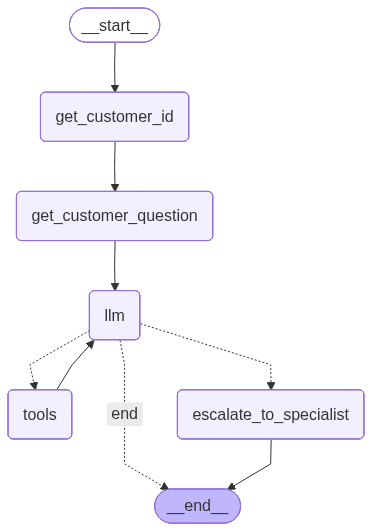

In [66]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [67]:
config = {"configurable": {"thread_id": "1"}}
for event in graph.stream(
    {"messages": [("human", "")]},
    stream_mode="updates",
    config=config,
):
    print(event)

{'__interrupt__': (Interrupt(value='üÜî Welcome to Customer Support! Can you please enter your Customer ID (CUSTXXX format)?', id='83944f026107abbb19c9165d21e9f18d'),)}


In [68]:
from langgraph.types import Command
for event in graph.stream(
    Command(resume="CUST001"),
    stream_mode="updates",
    config=config,
):
    print(event)
    print("\n")

üÜï New session for customer CUST001
‚úÖ Customer context retrieved for CUST001
‚úÖ Customer context: Customer Information:
Name: ÍπÄÎØºÏ§Ä
Email: kim.minjun@email.com
Plan: Premium
Status: active
Account Age: 365 days
Previous Issues: 2
{'get_customer_id': {'customer_id': 'CUST001', 'knowledge_base_results': [], 'web_search_raw_results': [], 'specialist_info': {}, 'customer_question': '', 'customer_context': 'Customer Information:\nName: ÍπÄÎØºÏ§Ä\nEmail: kim.minjun@email.com\nPlan: Premium\nStatus: active\nAccount Age: 365 days\nPrevious Issues: 2'}}


{'__interrupt__': (Interrupt(value='‚ùì Do you need any help? Please describe your issue or question:', id='d96659bf6b8f8f14585e231fb7be2145'),)}




In [69]:
for event in graph.stream(
    Command(resume="How do I reset my password? (Look at the knowledge base please)"),
    stream_mode="updates",
    config=config,
):
    print(event)
    print("\n")

{'get_customer_question': {'customer_question': 'How do I reset my password? (Look at the knowledge base please)'}}


ü§ñ Processing question for CUST001: How do I reset my password? (Look at the knowledge base please)...
First pass: LLM decides whether to use tools or answer directly
üîß System message: You are a Customer Service Assistant helping customer CUST001.
Customer context: Customer Information:
Name: ÍπÄÎØºÏ§Ä
Email: kim.minjun@email.com
Plan: Premium
Status: active
Account Age: 365 days
Previous...
üìä Tool results available: KB=0, Web=0
üîÑ LLM wants to use tools
{'llm': {'messages': [AIMessage(content='[This function is ESSENTIAL because the customer explicitly asked to look at the knowledge base for password reset instructions. The query directly addresses their request, and the results will provide the necessary steps.]  \n\nAfter retrieving the knowledge base results, I will summarize the password reset process for you. If the information is insufficient, I may fol

In [70]:
for event in graph.stream(
    {"messages": [("human", "")]},
    stream_mode="updates",
    config=config,
):
    print(event)

{'__interrupt__': (Interrupt(value='üÜî Welcome to Customer Support! Can you please enter your Customer ID (CUSTXXX format)?', id='12dcaf0afc04063d7ff452dd7df345b5'),)}


In [71]:
from langgraph.types import Command
for event in graph.stream(
    Command(resume="CUST001"),
    stream_mode="updates",
    config=config,
):
    print(event)
    print("\n")

üîÑ Same customer CUST001 - keeping existing context but resetting search results for new question
‚úÖ Customer context retrieved for CUST001
‚úÖ Customer context: Customer Information:
Name: ÍπÄÎØºÏ§Ä
Email: kim.minjun@email.com
Plan: Premium
Status: active
Account Age: 365 days
Previous Issues: 2
{'get_customer_id': {'customer_id': 'CUST001', 'knowledge_base_results': [], 'web_search_raw_results': [], 'specialist_info': {}, 'customer_question': '', 'customer_context': 'Customer Information:\nName: ÍπÄÎØºÏ§Ä\nEmail: kim.minjun@email.com\nPlan: Premium\nStatus: active\nAccount Age: 365 days\nPrevious Issues: 2'}}


{'__interrupt__': (Interrupt(value='‚ùì Do you need any help? Please describe your issue or question:', id='0e434bf76a63ec3c68ba23b71856c3aa'),)}




In [72]:
for event in graph.stream(
    Command(resume="What is the ERROR CODE 02342? (Look at the knowledge base first please)"),
    stream_mode="updates",
    config=config,
):
    print(event)
    print("\n")

{'get_customer_question': {'customer_question': 'What is the ERROR CODE 02342? (Look at the knowledge base first please)'}}


ü§ñ Processing question for CUST001: What is the ERROR CODE 02342? (Look at the knowledge base first please)...
First pass: LLM decides whether to use tools or answer directly
üîß System message: You are a Customer Service Assistant helping customer CUST001.
Customer context: Customer Information:
Name: ÍπÄÎØºÏ§Ä
Email: kim.minjun@email.com
Plan: Premium
Status: active
Account Age: 365 days
Previous...
üìä Tool results available: KB=0, Web=0
üîÑ LLM wants to use tools
{'llm': {'messages': [AIMessage(content='[This function is essential because the customer explicitly asked to check the knowledge base first for the error code explanation. The search will retrieve the most relevant information directly from our internal resources.]  \n\nIf the knowledge base doesn\'t provide a match, I\'ll follow up with a web search to ensure we cover all possible sources. Le

Ïó¨Í∏∞ÏÑúÎäî ÎÑòÏñ¥Í∞ÄÏÑú `langgraph dev` Î°ú ÌôïÏù∏Ìï¥Î¥ÖÏãúÎã§!